Fitted params from 0A (baseline):
  H: eps = 1.321e-06 m·rad, sigma_delta = 5.723e-04
  V: eps = 8.968e-07 m·rad, sigma_delta = 0.000e+00 (expect ~0)


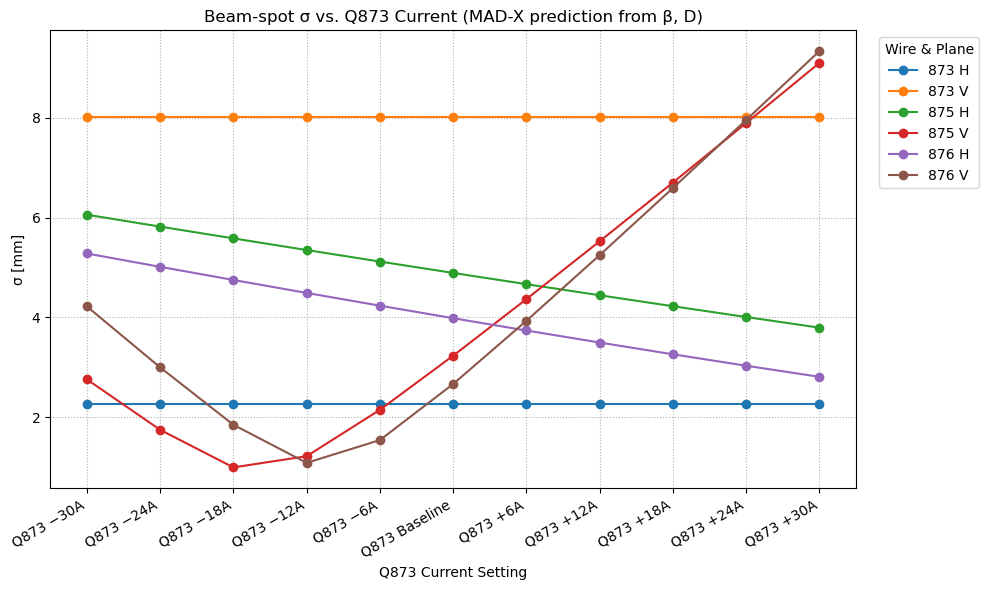

Wrote madx_pred_sigma_vs_current.csv


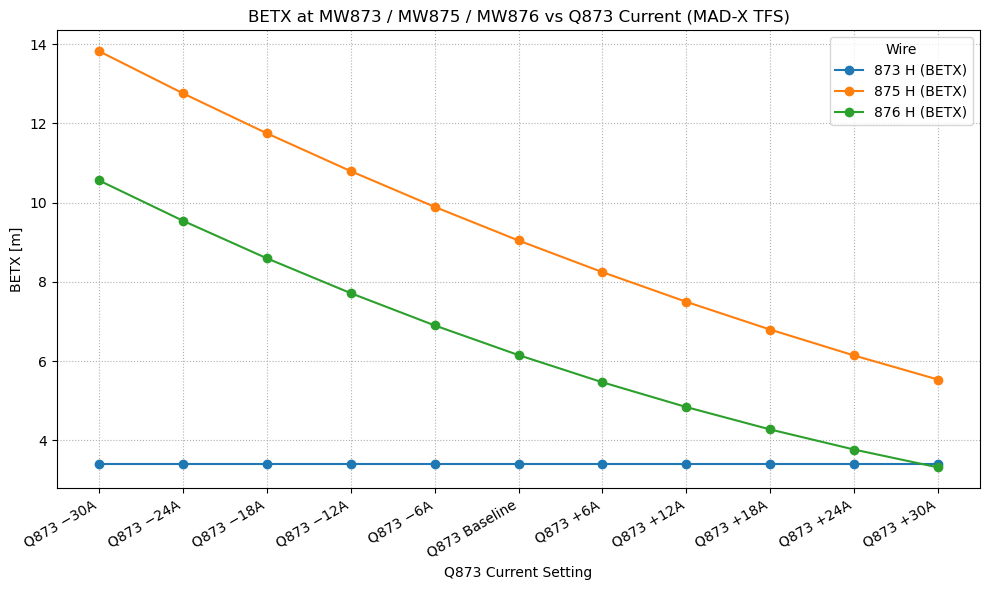

Wrote betax_vs_Q873_current.csv


In [1]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) File map & plot order
# -----------------------------
files = {
    "-30": "twiss_Q873_minus30A.tfs",
    "-24": "twiss_Q873_minus24A.tfs",
    "-18": "twiss_Q873_minus18A.tfs",
    "-12": "twiss_Q873_minus12A.tfs",
    "-6" : "twiss_Q873_minus6A.tfs",
    "0"  : "twiss_Q873_default.tfs",
    "+6" : "twiss_Q873_plus6A.tfs",
    "+12": "twiss_Q873_plus12A.tfs",
    "+18": "twiss_Q873_plus18A.tfs",
    "+24": "twiss_Q873_plus24A.tfs",
    "+30": "twiss_Q873_plus30A.tfs",
}
order = ["-30","-24","-18","-12","-6","0","+6","+12","+18","+24","+30"]
xlabels = {
    "-30":"Q873 −30A","-24":"Q873 −24A","-18":"Q873 −18A","-12":"Q873 −12A","-6":"Q873 −6A",
    "0":"Q873 Baseline","+6":"Q873 +6A","+12":"Q873 +12A","+18":"Q873 +18A","+24":"Q873 +24A","+30":"Q873 +30A"
}

monitors = ["MW873","MW875","MW876"]  # wires of interest

# -----------------------------
# 1) Robust TFS reader
# -----------------------------
def read_tfs(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header_idx = None
    for i, ln in enumerate(lines):
        if ln.lstrip().startswith("*"):
            header_idx = i
            break
    if header_idx is None:
        raise RuntimeError(f"No '*' header line in {path}")

    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()

    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1

    data_rows = []
    for ln in lines[start:]:
        if ln.strip() == "" or ln.lstrip().startswith(("@","#","*","$")):
            continue
        data_rows.append(ln)

    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=cols, engine="python")

    # Normalize case and names
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))  # drop suffixes like ':1', '..1'
    return df

# -----------------------------
# 2) Pick MW rows (873/875/876)
# -----------------------------
def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            # fallback to contains, just in case a weird suffix slipped through
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            existing = df[df["NAME"].str.contains("MW", na=False)]["NAME"].unique()
            raise RuntimeError(f"{w} not found. MW-like names present: {existing[:10]}")
        out[w] = m.iloc[0]  # first occurrence
    return out

# -----------------------------
# 3) Baseline measured σ (mm) at 0 A
# -----------------------------
baseline_measured_mm = {
    ("MW873","H"): 2.30, ("MW873","V"): 5.00,
    ("MW875","H"): 5.00, ("MW875","V"): 1.37,
    ("MW876","H"): 3.77, ("MW876","V"): 0.969,
}

# -----------------------------
# 4) Fit ε and σδ from baseline (0A)
#    s^2 = ε*β + (σδ^2)*D^2  for each plane
# -----------------------------
def fit_plane_params(baseline_rows, plane):
    beta_col = "BETX" if plane=="H" else "BETY"
    disp_col = "DX"   if plane=="H" else "DY"

    y = []
    X = []
    for w in monitors:
        sig_mm = baseline_measured_mm[(w,plane)]
        sig2_m2 = (sig_mm*1e-3)**2
        beta = float(baseline_rows[w][beta_col])
        disp = float(baseline_rows[w][disp_col])
        y.append(sig2_m2)
        X.append([beta, disp*disp])

    y = np.array(y)
    X = np.array(X)  # columns: [β, D^2]
    p, *_ = np.linalg.lstsq(X, y, rcond=None)  # [ε, σδ^2]
    eps, sdel2 = float(p[0]), float(p[1])
    return max(eps,0.0), max(sdel2,0.0)

# -----------------------------
# 5) Load baseline, fit, then predict σ for each offset
# -----------------------------
df0 = read_tfs(files["0"])
rows0 = get_mw_rows(df0)

eps_x, sdel2_x = fit_plane_params(rows0, "H")
eps_y, sdel2_y = fit_plane_params(rows0, "V")

print("Fitted params from 0A (baseline):")
print(f"  H: eps = {eps_x:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_x):.3e}")
print(f"  V: eps = {eps_y:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_y):.3e} (expect ~0)")

# Containers
sigma_pred = { (w,"H"):[] for w in monitors }
sigma_pred.update({ (w,"V"):[] for w in monitors })
betx = { w:[] for w in monitors }
labels_available = []

for key in order:
    path = files.get(key)
    if not path or not os.path.exists(path):
        print(f"Skipping (missing): {key} -> {path}")
        continue

    df = read_tfs(path)
    rows = get_mw_rows(df)
    labels_available.append(key)

    for w in monitors:
        # H plane σ prediction
        bx = float(rows[w]["BETX"])
        dx = float(rows[w]["DX"])
        sig_h_mm = math.sqrt(eps_x*bx + sdel2_x*(dx**2)) * 1e3
        sigma_pred[(w,"H")].append(sig_h_mm)

        # V plane σ prediction
        by = float(rows[w]["BETY"])
        dy = float(rows[w]["DY"])
        sig_v_mm = math.sqrt(eps_y*by + sdel2_y*(dy**2)) * 1e3
        sigma_pred[(w,"V")].append(sig_v_mm)

        # Save BETX too (for your betax vs current plot)
        betx[w].append(bx)

# -----------------------------
# 6a) Plot σ vs current (MAD-X prediction from β & D)
# -----------------------------
plt.figure(figsize=(10,6))
plot_order = [("MW873","H"),("MW873","V"),
              ("MW875","H"),("MW875","V"),
              ("MW876","H"),("MW876","V")]

xs = np.arange(len(labels_available))
for key in plot_order:
    y = sigma_pred[key]
    label = f"{key[0][-3:]} {key[1]}"
    plt.plot(xs, y, marker="o", label=label)

plt.xticks(xs, [xlabels[k] for k in labels_available], rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("σ [mm]")
plt.title("Beam-spot σ vs. Q873 Current (MAD-X prediction from β, D)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire & Plane", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Save CSV of σ predictions
pred_df = pd.DataFrame(
    {f"{w} {p}": sigma_pred[(w,p)] for (w,p) in plot_order},
    index=[xlabels[k] for k in labels_available]
)
pred_df.to_csv("madx_pred_sigma_vs_current.csv")
print("Wrote madx_pred_sigma_vs_current.csv")

# -----------------------------
# 6b) Plot BETX vs current (at the three MWs)
# -----------------------------
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, betx[w], marker="o", label=f"{w[-3:]} H (BETX)")
plt.xticks(xs, [xlabels[k] for k in labels_available], rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("BETX [m]")
plt.title("BETX at MW873 / MW875 / MW876 vs Q873 Current (MAD-X TFS)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# Save CSV of BETX values
betx_df = pd.DataFrame(
    {w: betx[w] for w in monitors},
    index=[xlabels[k] for k in labels_available]
)
betx_df.to_csv("betax_vs_Q873_current.csv")
print("Wrote betax_vs_Q873_current.csv")


Fitted params from 0A (baseline):
  H: eps = 1.321e-06 m·rad, sigma_delta = 5.723e-04
  V: eps = 8.968e-07 m·rad, sigma_delta = 0.000e+00 (expect ~0)


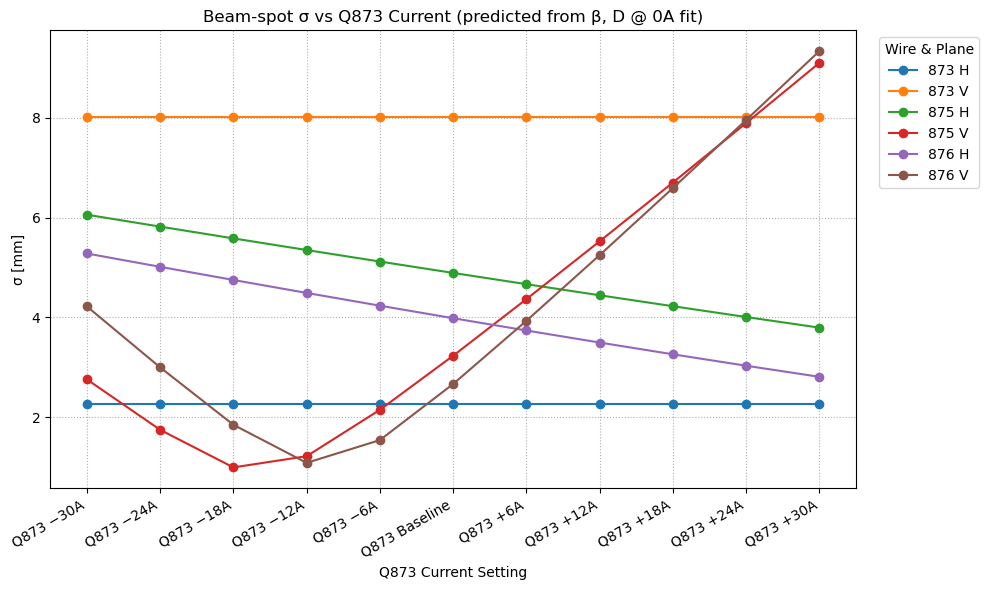

Wrote madx_pred_sigma_vs_current.csv


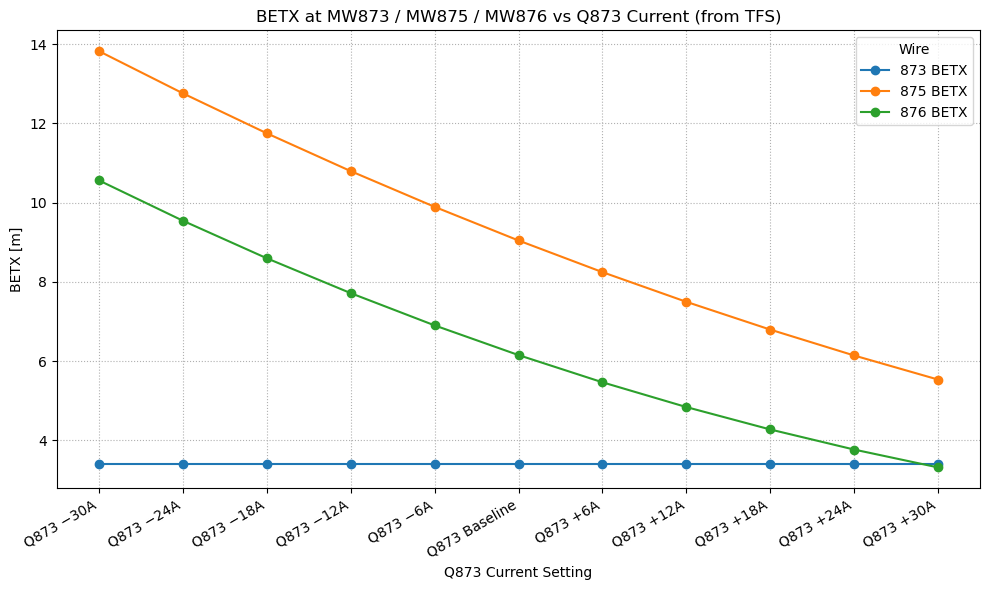

Wrote betax_vs_Q873_current.csv


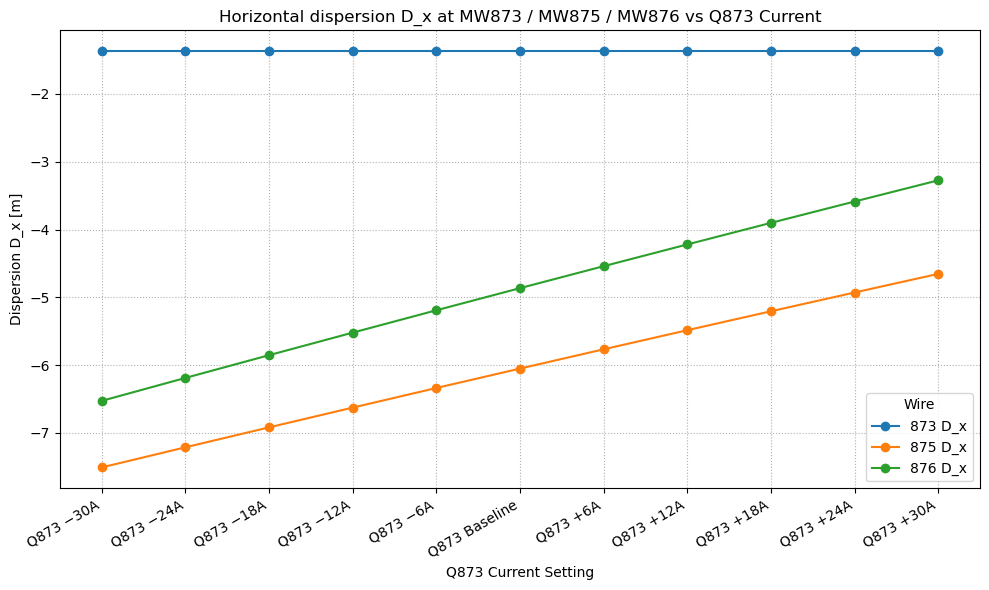

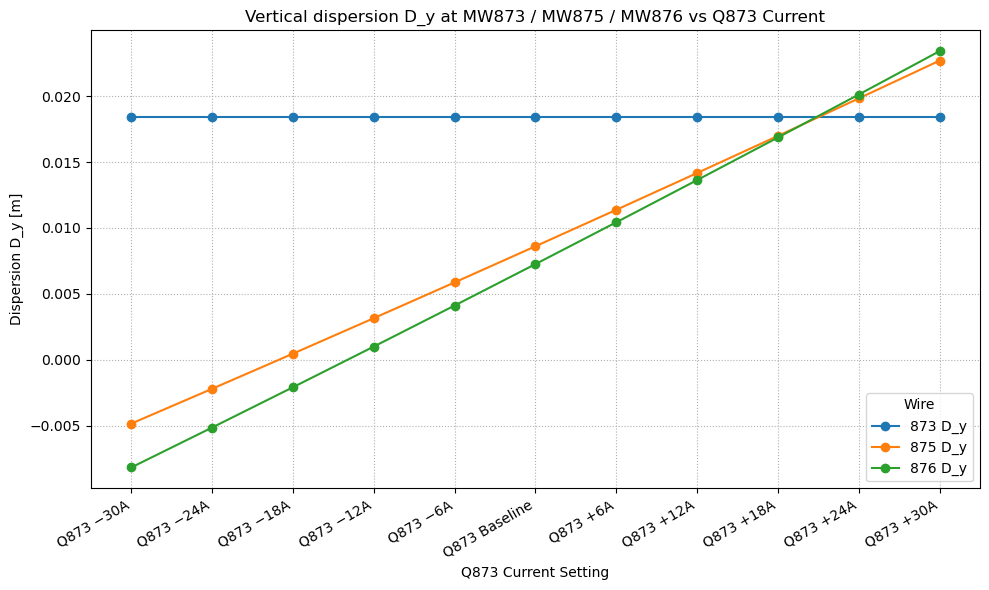

Wrote dispersion_vs_Q873_current.csv


In [2]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================
# 0) File map & current order / labels
# =========================================
files = {
    "-30": "twiss_Q873_minus30A.tfs",
    "-24": "twiss_Q873_minus24A.tfs",
    "-18": "twiss_Q873_minus18A.tfs",
    "-12": "twiss_Q873_minus12A.tfs",
    "-6" : "twiss_Q873_minus6A.tfs",
    "0"  : "twiss_Q873_default.tfs",
    "+6" : "twiss_Q873_plus6A.tfs",
    "+12": "twiss_Q873_plus12A.tfs",
    "+18": "twiss_Q873_plus18A.tfs",
    "+24": "twiss_Q873_plus24A.tfs",
    "+30": "twiss_Q873_plus30A.tfs",
}
order = ["-30","-24","-18","-12","-6","0","+6","+12","+18","+24","+30"]
xlabels = {
    "-30":"Q873 −30A","-24":"Q873 −24A","-18":"Q873 −18A","-12":"Q873 −12A","-6":"Q873 −6A",
    "0":"Q873 Baseline","+6":"Q873 +6A","+12":"Q873 +12A","+18":"Q873 +18A","+24":"Q873 +24A","+30":"Q873 +30A"
}
monitors = ["MW873","MW875","MW876"]  # wires of interest

# =========================================
# 1) Robust TFS reader
# =========================================
def read_tfs(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header_idx = None
    for i, ln in enumerate(lines):
        if ln.lstrip().startswith("*"):
            header_idx = i
            break
    if header_idx is None:
        raise RuntimeError(f"No '*' header line in {path}")

    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()

    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1

    data_rows = []
    for ln in lines[start:]:
        if ln.strip() == "" or ln.lstrip().startswith(("@","#","*","$")):
            continue
        data_rows.append(ln)

    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=cols, engine="python")

    # Normalize case and names; drop suffixes like ':1', '..1'
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

# =========================================
# 2) Pick MW rows (873/875/876)
# =========================================
def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            existing = df[df["NAME"].str.contains("MW", na=False)]["NAME"].unique()
            raise RuntimeError(f"{w} not found. MW-like names present: {existing[:10]}")
        out[w] = m.iloc[0]  # first occurrence
    return out

# =========================================
# 3) Baseline measured σ (mm) at 0 A
# =========================================
baseline_measured_mm = {
    ("MW873","H"): 2.30, ("MW873","V"): 5.00,
    ("MW875","H"): 5.00, ("MW875","V"): 1.37,
    ("MW876","H"): 3.77, ("MW876","V"): 0.969,
}

# =========================================
# 4) Fit ε and σδ from baseline (0A)
#    σ² = ε·β + (σδ²)·D²   (per plane)
# =========================================
def fit_plane_params(baseline_rows, plane):
    beta_col = "BETX" if plane=="H" else "BETY"
    disp_col = "DX"   if plane=="H" else "DY"

    y = []
    X = []
    for w in monitors:
        sig_mm = baseline_measured_mm[(w,plane)]
        sig2_m2 = (sig_mm*1e-3)**2
        beta = float(baseline_rows[w][beta_col])
        disp = float(baseline_rows[w][disp_col])
        y.append(sig2_m2)
        X.append([beta, disp*disp])

    y = np.array(y)
    X = np.array(X)  # columns: [β, D^2]
    p, *_ = np.linalg.lstsq(X, y, rcond=None)  # [ε, σδ^2]
    eps, sdel2 = float(p[0]), float(p[1])
    return max(eps,0.0), max(sdel2,0.0)

# =========================================
# 5) Load baseline, fit, then sweep files
# =========================================
df0 = read_tfs(files["0"])
rows0 = get_mw_rows(df0)

eps_x, sdel2_x = fit_plane_params(rows0, "H")
eps_y, sdel2_y = fit_plane_params(rows0, "V")

print("Fitted params from 0A (baseline):")
print(f"  H: eps = {eps_x:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_x):.3e}")
print(f"  V: eps = {eps_y:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_y):.3e} (expect ~0)")

# Containers
sigma_pred = { (w,"H"):[] for w in monitors }
sigma_pred.update({ (w,"V"):[] for w in monitors })
betx = { w:[] for w in monitors }
dx = { w:[] for w in monitors }
dy = { w:[] for w in monitors }
labels_available = []

for key in order:
    path = files.get(key)
    if not path or not os.path.exists(path):
        print(f"Skipping (missing): {key} -> {path}")
        continue

    df = read_tfs(path)
    rows = get_mw_rows(df)
    labels_available.append(key)

    for w in monitors:
        # H plane σ prediction
        bx = float(rows[w]["BETX"]); ddx = float(rows[w]["DX"])
        sig_h_mm = math.sqrt(eps_x*bx + sdel2_x*(ddx**2)) * 1e3
        sigma_pred[(w,"H")].append(sig_h_mm)

        # V plane σ prediction
        by = float(rows[w]["BETY"]); ddy = float(rows[w]["DY"])
        sig_v_mm = math.sqrt(eps_y*by + sdel2_y*(ddy**2)) * 1e3
        sigma_pred[(w,"V")].append(sig_v_mm)

        # Save optics
        betx[w].append(bx)
        dx[w].append(ddx)
        dy[w].append(ddy)

# numeric x for proper spacing; nice labels on ticks
xs = np.array([int(k) for k in labels_available])
xtick_labels = [xlabels[k] for k in labels_available]

# =========================================
# 6a) Plot σ vs current (MAD-X prediction)
# =========================================
plt.figure(figsize=(10,6))
plot_order = [("MW873","H"),("MW873","V"),
              ("MW875","H"),("MW875","V"),
              ("MW876","H"),("MW876","V")]

for key in plot_order:
    y = sigma_pred[key]
    label = f"{key[0][-3:]} {key[1]}"
    plt.plot(xs, y, marker="o", label=label)

plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("σ [mm]")
plt.title("Beam-spot σ vs Q873 Current (predicted from β, D @ 0A fit)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire & Plane", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Save CSV of σ predictions
pred_df = pd.DataFrame(
    {f"{w} {p}": sigma_pred[(w,p)] for (w,p) in plot_order},
    index=xtick_labels
)
pred_df.to_csv("madx_pred_sigma_vs_current.csv")
print("Wrote madx_pred_sigma_vs_current.csv")

# =========================================
# 6b) Plot BETX vs current (three MWs)
# =========================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, betx[w], marker="o", label=f"{w[-3:]} BETX")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("BETX [m]")
plt.title("BETX at MW873 / MW875 / MW876 vs Q873 Current (from TFS)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# Save CSV of BETX values
betx_df = pd.DataFrame({w: betx[w] for w in monitors}, index=xtick_labels)
betx_df.to_csv("betax_vs_Q873_current.csv")
print("Wrote betax_vs_Q873_current.csv")

# =========================================
# 6c) Plot DX vs current
# =========================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, dx[w], marker="o", label=f"{w[-3:]} D_x")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("Dispersion D_x [m]")
plt.title("Horizontal dispersion D_x at MW873 / MW875 / MW876 vs Q873 Current")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# =========================================
# 6d) Plot DY vs current (usually ~0)
# =========================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, dy[w], marker="o", label=f"{w[-3:]} D_y")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("Dispersion D_y [m]")
plt.title("Vertical dispersion D_y at MW873 / MW875 / MW876 vs Q873 Current")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# Save CSV of dispersions
disp_cols = {}
for w in monitors:
    disp_cols[f"{w} D_x"] = dx[w]
for w in monitors:
    disp_cols[f"{w} D_y"] = dy[w]
disp_df = pd.DataFrame(disp_cols, index=xtick_labels)
disp_df.to_csv("dispersion_vs_Q873_current.csv")
print("Wrote dispersion_vs_Q873_current.csv")


Fitted params from 0A (baseline):
  H: eps = 1.322e-06 m·rad, sigma_delta = 5.648e-04
  V: eps = 8.754e-07 m·rad, sigma_delta = 0.000e+00 (expect ~0)


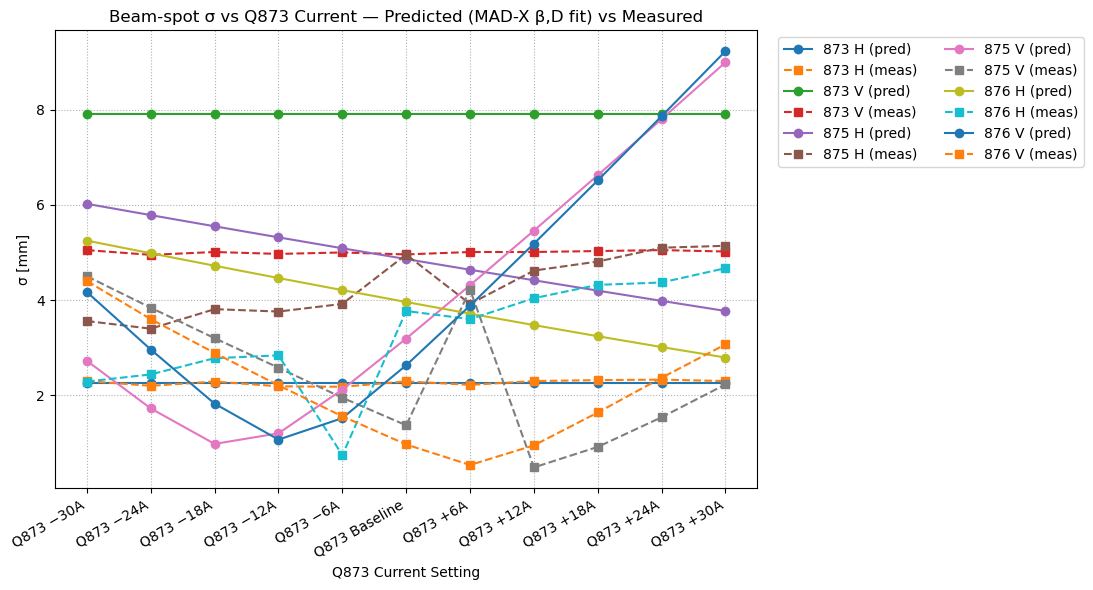

In [3]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================
# 0) File map & current order / labels
# =========================================
files = {
    "-30": "twiss_Q873_minus30A.tfs",
    "-24": "twiss_Q873_minus24A.tfs",
    "-18": "twiss_Q873_minus18A.tfs",
    "-12": "twiss_Q873_minus12A.tfs",
    "-6" : "twiss_Q873_minus6A.tfs",
    "0"  : "twiss_Q873_default.tfs",
    "+6" : "twiss_Q873_plus6A.tfs",
    "+12": "twiss_Q873_plus12A.tfs",
    "+18": "twiss_Q873_plus18A.tfs",
    "+24": "twiss_Q873_plus24A.tfs",
    "+30": "twiss_Q873_plus30A.tfs",
}
order = ["-30","-24","-18","-12","-6","0","+6","+12","+18","+24","+30"]
xlabels = {
    "-30":"Q873 −30A","-24":"Q873 −24A","-18":"Q873 −18A","-12":"Q873 −12A","-6":"Q873 −6A",
    "0":"Q873 Baseline","+6":"Q873 +6A","+12":"Q873 +12A","+18":"Q873 +18A","+24":"Q873 +24A","+30":"Q873 +30A"
}
monitors = ["MW873","MW875","MW876"]  # wires of interest

# =========================================
# Measured σ table (mm)
# =========================================
meas_data = {
    "Q873 − 30A":    [2.30,  5.05,  3.56,  4.50,  2.29,  4.40],
    "Q873 − 24A":    [2.20,  4.95,  3.40,  3.84,  2.44,  3.60],
    "Q873 − 18A":    [2.29,  5.01,  3.81,  3.20,  2.78,  2.89],
    "Q873 − 12A":    [2.19,  4.97,  3.76,  2.58,  2.84,  2.21],
    "Q873 − 6A":     [2.18,  5.00,  3.92,  1.95,  0.745, 1.56],
    "Q873 Baseline": [2.293, 4.959, 4.957, 1.371, 3.771, 0.9685],
    "Q873 + 6A":     [2.22,  5.01,  3.92,  4.22,  3.60,  0.538],
    "Q873 + 12A":    [2.30,  5.01,  4.62,  0.487, 4.04,  0.950],
    "Q873 + 18A":    [2.32,  5.03,  4.81,  0.918, 4.32,  1.64],
    "Q873 + 24A":    [2.33,  5.05,  5.10,  1.54,  4.37,  2.37],
    "Q873 + 30A":    [2.30,  5.02,  5.14,  2.23,  4.67,  3.07],
}
meas_df = pd.DataFrame.from_dict(
    meas_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

# Helper: find a measurement row by label while ignoring extra spaces
def find_meas_row(label):
    target = label.replace(" ", "")
    for idx in meas_df.index:
        if idx.replace(" ", "") == target:
            return meas_df.loc[idx]
    raise KeyError(f"Measurement row not found for label '{label}'. "
                   f"Available: {list(meas_df.index)}")

# =========================================
# 1) Robust TFS reader
# =========================================
def read_tfs(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header_idx = None
    for i, ln in enumerate(lines):
        if ln.lstrip().startswith("*"):
            header_idx = i
            break
    if header_idx is None:
        raise RuntimeError(f"No '*' header line in {path}")

    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()

    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1

    data_rows = []
    for ln in lines[start:]:
        if ln.strip() == "" or ln.lstrip().startswith(("@","#","*","$")):
            continue
        data_rows.append(ln)

    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=cols, engine="python")

    # Normalize case and names; drop suffixes like ':1', '..1'
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

# =========================================
# 2) Pick MW rows (873/875/876)
# =========================================
def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            existing = df[df["NAME"].str.contains("MW", na=False)]["NAME"].unique()
            raise RuntimeError(f"{w} not found. MW-like names present: {existing[:10]}")
        out[w] = m.iloc[0]  # first occurrence
    return out

# =========================================
# 3) Fit ε and σδ from baseline (0A)
#    σ² = ε·β + (σδ²)·D²   (per plane)
# =========================================
def fit_plane_params(baseline_rows, baseline_meas_mm, plane):
    beta_col = "BETX" if plane=="H" else "BETY"
    disp_col = "DX"   if plane=="H" else "DY"

    y = []
    X = []
    for w, short in (("MW873","873"),("MW875","875"),("MW876","876")):
        sig_mm = baseline_meas_mm[f"{short} {plane}"]
        sig2_m2 = (sig_mm*1e-3)**2
        beta = float(baseline_rows[w][beta_col])
        disp = float(baseline_rows[w][disp_col])
        y.append(sig2_m2)
        X.append([beta, disp*disp])

    y = np.array(y)
    X = np.array(X)  # columns: [β, D^2]
    p, *_ = np.linalg.lstsq(X, y, rcond=None)  # [ε, σδ^2]
    eps, sdel2 = float(p[0]), float(p[1])
    return max(eps,0.0), max(sdel2,0.0)

# Load baseline optics
df0 = read_tfs(files["0"])
rows0 = get_mw_rows(df0)

# Pull baseline measured σ from your table (robust match)
base = find_meas_row("Q873 Baseline")
baseline_measured_mm = {
    "873 H": base["873 H"], "873 V": base["873 V"],
    "875 H": base["875 H"], "875 V": base["875 V"],
    "876 H": base["876 H"], "876 V": base["876 V"],
}

# Fit params
eps_x, sdel2_x = fit_plane_params(rows0, baseline_measured_mm, "H")
eps_y, sdel2_y = fit_plane_params(rows0, baseline_measured_mm, "V")

print("Fitted params from 0A (baseline):")
print(f"  H: eps = {eps_x:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_x):.3e}")
print(f"  V: eps = {eps_y:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_y):.3e} (expect ~0)")

# =========================================
# 4) Sweep files: predicted σ, labels
# =========================================
sigma_pred = { (w,"H"):[] for w in monitors }
sigma_pred.update({ (w,"V"):[] for w in monitors })
labels_available = []

for key in order:
    path = files.get(key)
    if not path or not os.path.exists(path):
        print(f"Skipping (missing): {key} -> {path}")
        continue

    df = read_tfs(path)
    rows = get_mw_rows(df)
    labels_available.append(key)

    for w in monitors:
        # H plane σ prediction
        bx = float(rows[w]["BETX"]); ddx = float(rows[w]["DX"])
        sig_h_mm = math.sqrt(eps_x*bx + sdel2_x*(ddx**2)) * 1e3
        sigma_pred[(w,"H")].append(sig_h_mm)

        # V plane σ prediction
        by = float(rows[w]["BETY"]); ddy = float(rows[w]["DY"])
        sig_v_mm = math.sqrt(eps_y*by + sdel2_y*(ddy**2)) * 1e3
        sigma_pred[(w,"V")].append(sig_v_mm)

# numeric x for spacing; nice labels on ticks
xs = np.array([int(k) for k in labels_available])
xtick_labels = [xlabels[k] for k in labels_available]

# Build measured series aligned to labels_available (robust lookup)
meas_series = {("MW873","H"):[], ("MW873","V"):[],
               ("MW875","H"):[], ("MW875","V"):[],
               ("MW876","H"):[], ("MW876","V"):[]}

for key in labels_available:
    lbl = xlabels[key]  # e.g. "Q873 +6A" or "Q873 −30A"
    row = find_meas_row(lbl)
    meas_series[("MW873","H")].append(row["873 H"])
    meas_series[("MW873","V")].append(row["873 V"])
    meas_series[("MW875","H")].append(row["875 H"])
    meas_series[("MW875","V")].append(row["875 V"])
    meas_series[("MW876","H")].append(row["876 H"])
    meas_series[("MW876","V")].append(row["876 V"])

# =========================================
# 5) Plot σ: predicted (solid) + measured (dashed)
# =========================================
plt.figure(figsize=(11,6))
plot_order = [("MW873","H"),("MW873","V"),
              ("MW875","H"),("MW875","V"),
              ("MW876","H"),("MW876","V")]

for key in plot_order:
    label_base = f"{key[0][-3:]} {key[1]}"
    # predicted
    plt.plot(xs, sigma_pred[key], marker="o", linestyle="-", label=f"{label_base} (pred)")
    # measured
    plt.plot(xs, meas_series[key], marker="s", linestyle="--", label=f"{label_base} (meas)")

plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("σ [mm]")
plt.title("Beam-spot σ vs Q873 Current — Predicted (MAD-X β,D fit) vs Measured")
plt.grid(True, linestyle=":")
plt.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


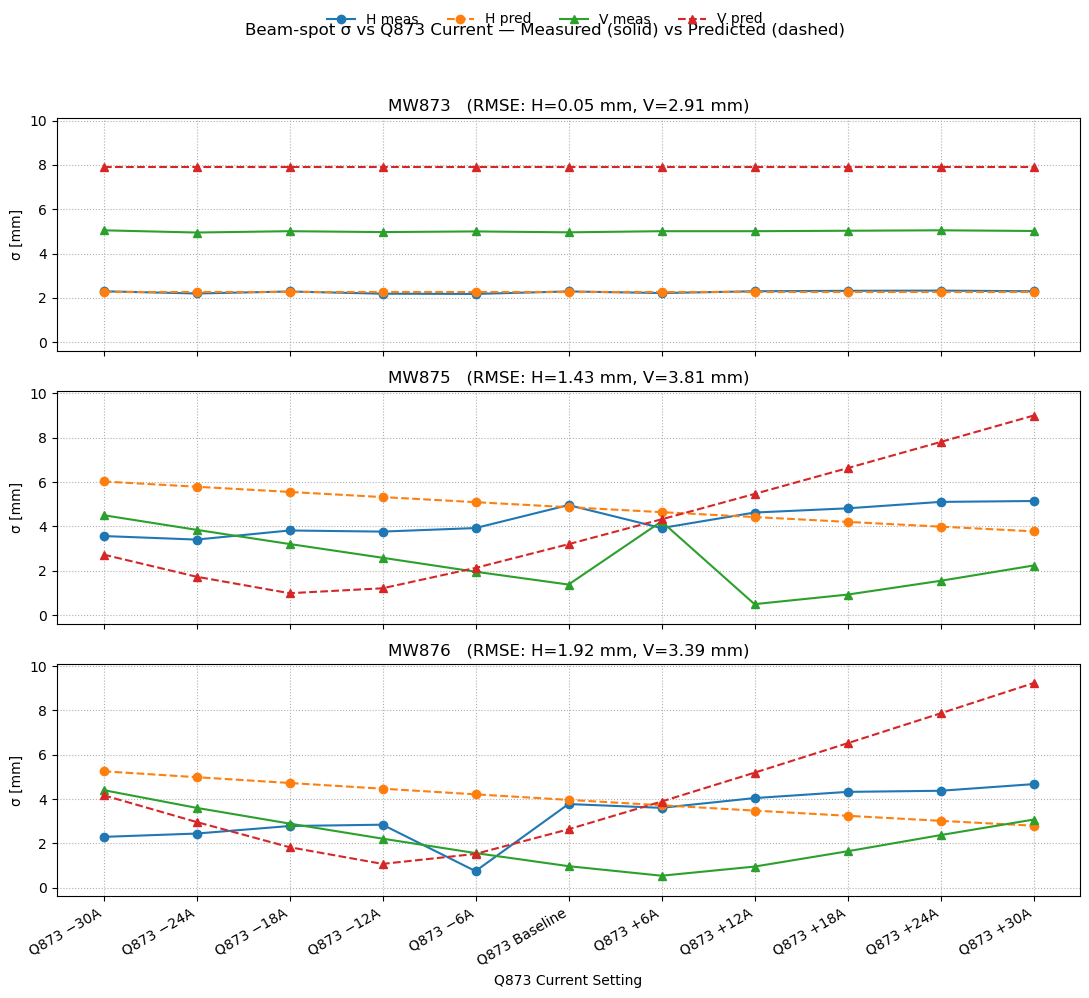

In [4]:
# ---------- OVERLAY PLOTS: one panel per wire ----------
import numpy as np
import matplotlib.pyplot as plt

def _rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a-b)**2)))

fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
global_lo, global_hi = 1e9, -1e9

for ax, w in zip(axes, ["MW873","MW875","MW876"]):
    # series
    yH_pred = sigma_pred[(w,"H")]
    yV_pred = sigma_pred[(w,"V")]
    yH_meas = meas_series[(w,"H")]
    yV_meas = meas_series[(w,"V")]

    # lines: solid = measured, dashed = predicted; markers differ by plane
    ax.plot(xs, yH_meas, marker="o", linestyle="-",  label="H meas")
    ax.plot(xs, yH_pred, marker="o", linestyle="--", label="H pred")
    ax.plot(xs, yV_meas, marker="^", linestyle="-",  label="V meas")
    ax.plot(xs, yV_pred, marker="^", linestyle="--", label="V pred")

    # RMSE in subtitle for quick read
    rmseH = _rmse(yH_meas, yH_pred)
    rmseV = _rmse(yV_meas, yV_pred)
    ax.set_title(f"{w}   (RMSE: H={rmseH:.2f} mm, V={rmseV:.2f} mm)")

    ax.grid(True, linestyle=":")

    # track global y-lims to align panels
    local_lo = min(yH_meas + yH_pred + yV_meas + yV_pred)
    local_hi = max(yH_meas + yH_pred + yV_meas + yV_pred)
    global_lo = min(global_lo, local_lo)
    global_hi = max(global_hi, local_hi)

# harmonize y limits across panels with a little headroom
pad = 0.1*(global_hi - global_lo if global_hi > global_lo else 1.0)
for ax in axes:
    ax.set_ylim(global_lo - pad, global_hi + pad)

axes[-1].set_xticks(xs, xtick_labels, rotation=30, ha="right")
axes[-1].set_xlabel("Q873 Current Setting")
for ax in axes:
    ax.set_ylabel("σ [mm]")

# one legend for all
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4, frameon=False)
fig.suptitle("Beam-spot σ vs Q873 Current — Measured (solid) vs Predicted (dashed)")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


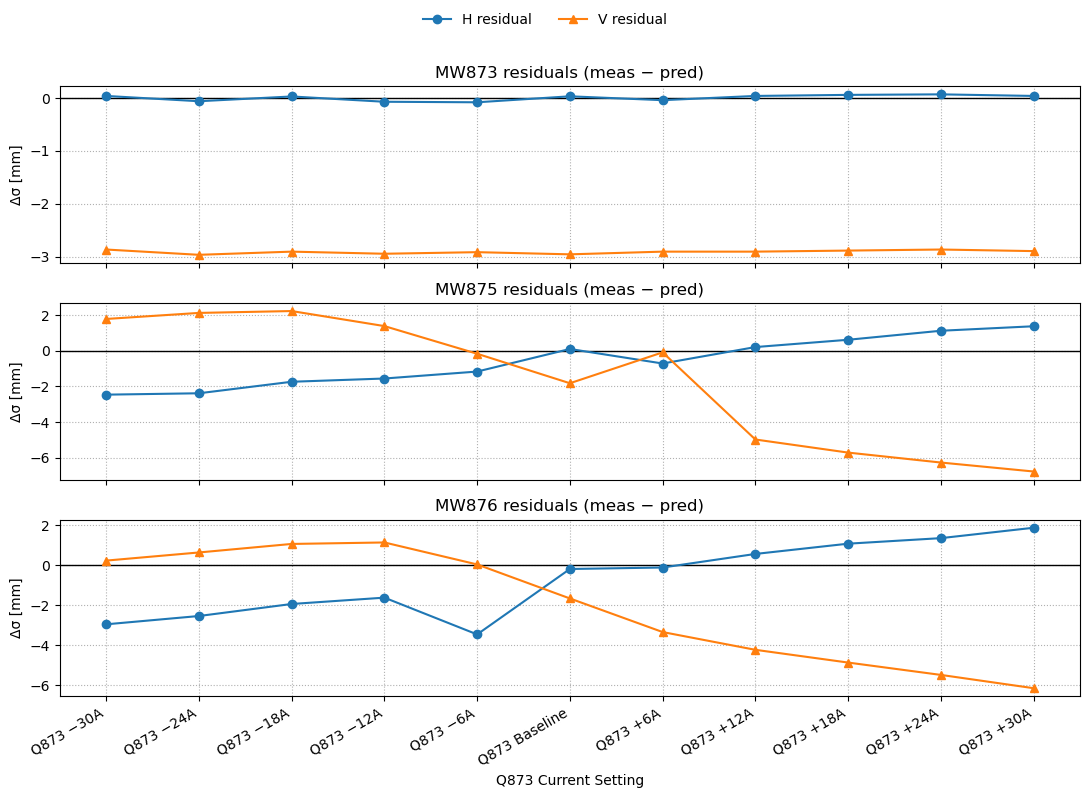

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(11, 8), sharex=True)
for ax, w in zip(axes, ["MW873","MW875","MW876"]):
    resH = np.array(meas_series[(w,"H")]) - np.array(sigma_pred[(w,"H")])
    resV = np.array(meas_series[(w,"V")]) - np.array(sigma_pred[(w,"V")])
    ax.axhline(0.0, color="k", linewidth=1)
    ax.plot(xs, resH, marker="o", linestyle="-",  label="H residual")
    ax.plot(xs, resV, marker="^", linestyle="-",  label="V residual")
    ax.set_title(f"{w} residuals (meas − pred)")
    ax.set_ylabel("Δσ [mm]")
    ax.grid(True, linestyle=":")
axes[-1].set_xticks(xs, xtick_labels, rotation=30, ha="right")
axes[-1].set_xlabel("Q873 Current Setting")
fig.legend(*axes[0].get_legend_handles_labels(), loc="upper center", ncol=4, frameon=False)
fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


Fitted params from 0A (baseline):
  H: eps = 1.321e-06 m·rad, sigma_delta = 5.723e-04
  V: eps = 8.968e-07 m·rad, sigma_delta = 0.000e+00 (expect ~0)

Files used:
  Q873 −30A -> twiss_Q873_-30A_flipPol.tfs
  Q873 −24A -> twiss_Q873_-24A_flipPol.tfs
  Q873 −18A -> twiss_Q873_-18A_flipPol.tfs
  Q873 −12A -> twiss_Q873_-12A_flipPol.tfs
  Q873 −6A -> twiss_Q873_-6A_flipPol.tfs
  Q873 Baseline -> twiss_Q873_default.tfs
  Q873 +6A -> twiss_Q873_+6A_flipPol.tfs
  Q873 +12A -> twiss_Q873_+12A_flipPol.tfs
  Q873 +18A -> twiss_Q873_+18A_flipPol.tfs
  Q873 +24A -> twiss_Q873_+24A_flipPol.tfs
  Q873 +30A -> twiss_Q873_+30A_flipPol.tfs


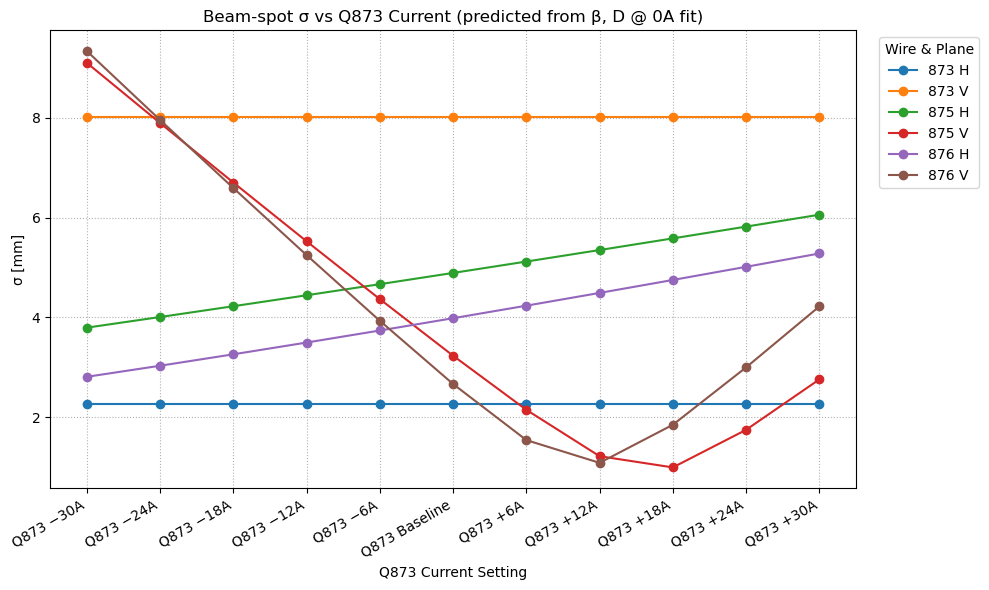


Wrote madx_pred_sigma_vs_current_flipPol.csv


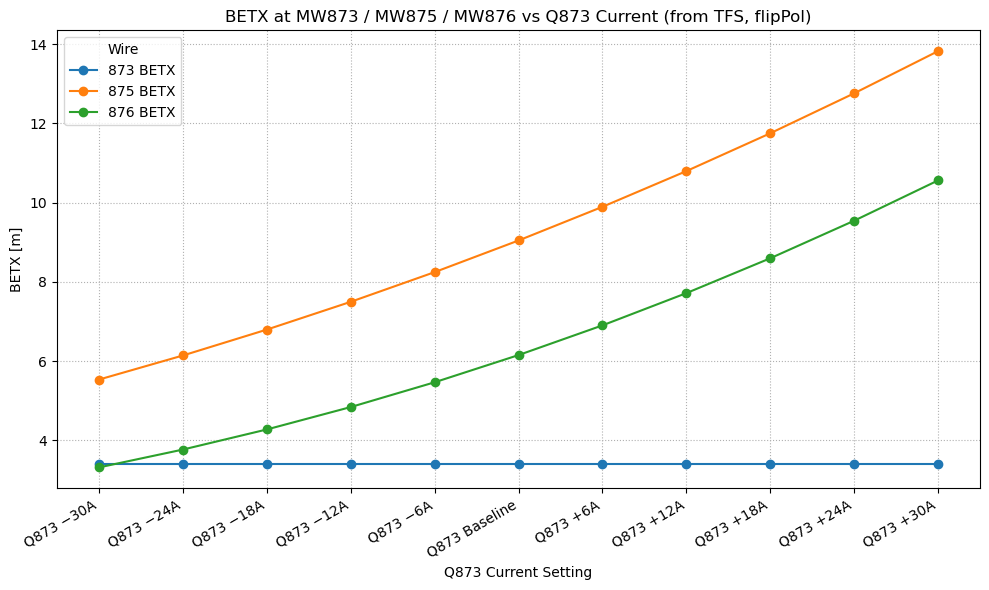

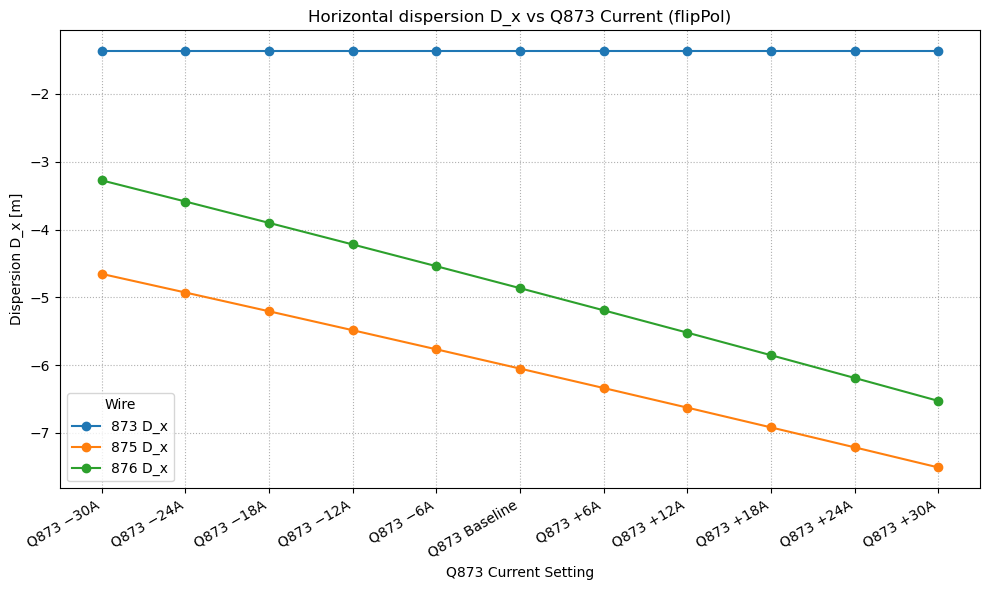

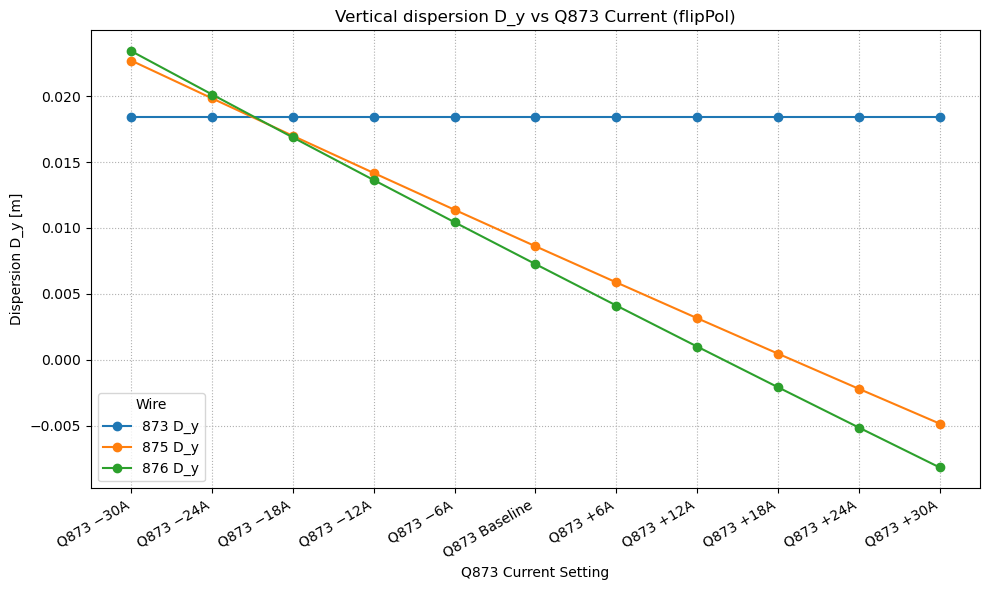

Wrote betax_vs_Q873_current_flipPol.csv and dispersion_vs_Q873_current_flipPol.csv


In [6]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =================================================================================
# Switch to flipped-polarity files. We auto-detect per current; fallback to old names
# =================================================================================
USE_FLIPPED = True

order = ["-30","-24","-18","-12","-6","0","+6","+12","+18","+24","+30"]
xlabels = {
    "-30":"Q873 −30A","-24":"Q873 −24A","-18":"Q873 −18A","-12":"Q873 −12A","-6":"Q873 −6A",
    "0":"Q873 Baseline","+6":"Q873 +6A","+12":"Q873 +12A","+18":"Q873 +18A","+24":"Q873 +24A","+30":"Q873 +30A"
}
monitors = ["MW873","MW875","MW876"]

# Old (non-flipped) mapping for fallback
OLD_FILES = {
    "-30": "twiss_Q873_minus30A.tfs",
    "-24": "twiss_Q873_minus24A.tfs",
    "-18": "twiss_Q873_minus18A.tfs",
    "-12": "twiss_Q873_minus12A.tfs",
    "-6" : "twiss_Q873_minus6A.tfs",
    "0"  : "twiss_Q873_default.tfs",
    "+6" : "twiss_Q873_plus6A.tfs",
    "+12": "twiss_Q873_plus12A.tfs",
    "+18": "twiss_Q873_plus18A.tfs",
    "+24": "twiss_Q873_plus24A.tfs",
    "+30": "twiss_Q873_plus30A.tfs",
}

def pick_file_for_current(key, use_flipped=True):
    """Return the best-available filename for a given current key."""
    candidates = []
    if key == "0":
        candidates.append("twiss_Q873_default.tfs")
    else:
        if use_flipped:
            # Your new flipped-polarity filenames, e.g. twiss_Q873_+6A_flipPol.tfs
            candidates.append(f"twiss_Q873_{key}A_flipPol.tfs")
        # fall back to the old names
        if key in OLD_FILES:
            candidates.append(OLD_FILES[key])
    for c in candidates:
        if os.path.exists(c):
            return c
    # nothing found -> return first candidate (for error message later)
    return candidates[0] if candidates else None

# Build the files dict dynamically
files = {}
for k in order:
    fname = pick_file_for_current(k, USE_FLIPPED)
    files[k] = fname

# =========================================
# Robust TFS reader
# =========================================
def read_tfs(path):
    if not path or not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header_idx = None
    for i, ln in enumerate(lines):
        if ln.lstrip().startswith("*"):
            header_idx = i
            break
    if header_idx is None:
        raise RuntimeError(f"No '*' header line in {path}")

    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()

    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1

    data_rows = []
    for ln in lines[start:]:
        if ln.strip() == "" or ln.lstrip().startswith(("@","#","*","$")):
            continue
        data_rows.append(ln)

    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=cols, engine="python")

    # Normalize names; drop suffixes like ':1', '..1'
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            existing = df[df["NAME"].str.contains("MW", na=False)]["NAME"].unique()
            raise RuntimeError(f"{w} not found. MW-like names present: {existing[:10]}")
        out[w] = m.iloc[0]
    return out

# =========================================
# Baseline measured σ (mm) at 0 A
# =========================================
baseline_measured_mm = {
    ("MW873","H"): 2.30, ("MW873","V"): 5.00,
    ("MW875","H"): 5.00, ("MW875","V"): 1.37,
    ("MW876","H"): 3.77, ("MW876","V"): 0.969,
}

# =========================================
# Fit ε and σδ from baseline (0A)
#   σ² = ε·β + (σδ²)·D² (per plane)
# =========================================
def fit_plane_params(baseline_rows, plane):
    beta_col = "BETX" if plane=="H" else "BETY"
    disp_col = "DX"   if plane=="H" else "DY"

    y = []
    X = []
    for w in monitors:
        sig_mm = baseline_measured_mm[(w,plane)]
        sig2_m2 = (sig_mm*1e-3)**2
        beta = float(baseline_rows[w][beta_col])
        disp = float(baseline_rows[w][disp_col])
        y.append(sig2_m2)
        X.append([beta, disp*disp])

    y = np.array(y)
    X = np.array(X)
    p, *_ = np.linalg.lstsq(X, y, rcond=None)  # [ε, σδ^2]
    eps, sdel2 = float(p[0]), float(p[1])
    return max(eps,0.0), max(sdel2,0.0)

# =========================================
# Load baseline, fit, then sweep files
# =========================================
df0 = read_tfs(files["0"])
rows0 = get_mw_rows(df0)

eps_x, sdel2_x = fit_plane_params(rows0, "H")
eps_y, sdel2_y = fit_plane_params(rows0, "V")

print("Fitted params from 0A (baseline):")
print(f"  H: eps = {eps_x:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_x):.3e}")
print(f"  V: eps = {eps_y:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_y):.3e} (expect ~0)")

sigma_pred = { (w,"H"):[] for w in monitors }
sigma_pred.update({ (w,"V"):[] for w in monitors })
betx = { w:[] for w in monitors }
dx = { w:[] for w in monitors }
dy = { w:[] for w in monitors }
labels_available = []
files_used = []

for key in order:
    path = files.get(key)
    if not path or not os.path.exists(path):
        print(f"Skipping (missing): {key} -> {path}")
        continue

    df = read_tfs(path)
    rows = get_mw_rows(df)
    labels_available.append(key)
    files_used.append((key, path))

    for w in monitors:
        bx = float(rows[w]["BETX"]); ddx = float(rows[w]["DX"])
        by = float(rows[w]["BETY"]); ddy = float(rows[w]["DY"])

        sig_h_mm = math.sqrt(eps_x*bx + sdel2_x*(ddx**2)) * 1e3
        sig_v_mm = math.sqrt(eps_y*by + sdel2_y*(ddy**2)) * 1e3

        sigma_pred[(w,"H")].append(sig_h_mm)
        sigma_pred[(w,"V")].append(sig_v_mm)

        betx[w].append(bx)
        dx[w].append(ddx)
        dy[w].append(ddy)

# helpful printout of which files were actually used
print("\nFiles used:")
for k, p in files_used:
    print(f"  {xlabels[k]} -> {p}")

xs = np.array([int(k) for k in labels_available])
xtick_labels = [xlabels[k] for k in labels_available]

# =========================================
# σ vs current (prediction)
# =========================================
plt.figure(figsize=(10,6))
plot_order = [("MW873","H"),("MW873","V"),
              ("MW875","H"),("MW875","V"),
              ("MW876","H"),("MW876","V")]
for key in plot_order:
    y = sigma_pred[key]
    label = f"{key[0][-3:]} {key[1]}"
    plt.plot(xs, y, marker="o", label=label)

plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("σ [mm]")
plt.title("Beam-spot σ vs Q873 Current (predicted from β, D @ 0A fit)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire & Plane", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Save CSV
pred_df = pd.DataFrame(
    {f"{w} {p}": sigma_pred[(w,p)] for (w,p) in plot_order},
    index=xtick_labels
)
pred_df.to_csv("madx_pred_sigma_vs_current_flipPol.csv")
print("\nWrote madx_pred_sigma_vs_current_flipPol.csv")

# =========================================
# BETX vs current
# =========================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, betx[w], marker="o", label=f"{w[-3:]} BETX")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("BETX [m]")
plt.title("BETX at MW873 / MW875 / MW876 vs Q873 Current (from TFS, flipPol)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# =========================================
# Dispersion Dx / Dy vs current
# =========================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, dx[w], marker="o", label=f"{w[-3:]} D_x")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("Dispersion D_x [m]")
plt.title("Horizontal dispersion D_x vs Q873 Current (flipPol)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, dy[w], marker="o", label=f"{w[-3:]} D_y")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("Dispersion D_y [m]")
plt.title("Vertical dispersion D_y vs Q873 Current (flipPol)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# Save optics/dispersion CSVs
pd.DataFrame({w: betx[w] for w in monitors}, index=xtick_labels)\
  .to_csv("betax_vs_Q873_current_flipPol.csv")
pd.DataFrame({f"{w} D_x": dx[w] for w in monitors} | {f"{w} D_y": dy[w] for w in monitors},
             index=xtick_labels)\
  .to_csv("dispersion_vs_Q873_current_flipPol.csv")
print("Wrote betax_vs_Q873_current_flipPol.csv and dispersion_vs_Q873_current_flipPol.csv")


Fitted params from 0A (baseline):
  H: eps = 1.322e-06 m·rad, sigma_delta = 5.648e-04
  V: eps = 8.754e-07 m·rad, sigma_delta = 0.000e+00 (expect ~0)

Files used:
  Q873 −30A -> twiss_Q873_-30A_flipPol.tfs
  Q873 −24A -> twiss_Q873_-24A_flipPol.tfs
  Q873 −18A -> twiss_Q873_-18A_flipPol.tfs
  Q873 −12A -> twiss_Q873_-12A_flipPol.tfs
  Q873 −6A -> twiss_Q873_-6A_flipPol.tfs
  Q873 Baseline -> twiss_Q873_default.tfs
  Q873 +6A -> twiss_Q873_+6A_flipPol.tfs
  Q873 +12A -> twiss_Q873_+12A_flipPol.tfs
  Q873 +18A -> twiss_Q873_+18A_flipPol.tfs
  Q873 +24A -> twiss_Q873_+24A_flipPol.tfs
  Q873 +30A -> twiss_Q873_+30A_flipPol.tfs


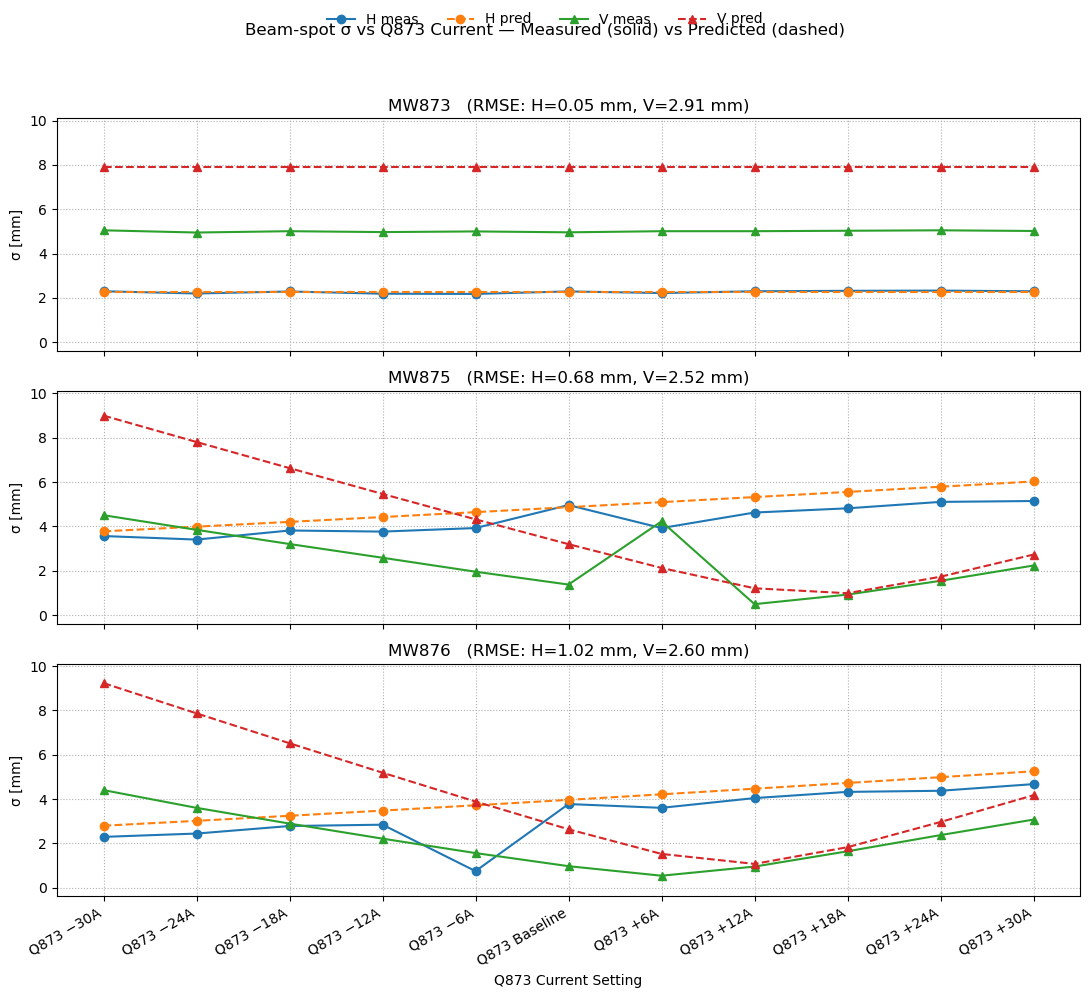

In [7]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================
# 0) Current order / labels
# =========================================
order = ["-30","-24","-18","-12","-6","0","+6","+12","+18","+24","+30"]
xlabels = {
    "-30":"Q873 −30A","-24":"Q873 −24A","-18":"Q873 −18A","-12":"Q873 −12A","-6":"Q873 −6A",
    "0":"Q873 Baseline","+6":"Q873 +6A","+12":"Q873 +12A","+18":"Q873 +18A","+24":"Q873 +24A","+30":"Q873 +30A"
}
monitors = ["MW873","MW875","MW876"]  # wires of interest

# Old (non-flipped) filenames (fallback if a flipPol file is missing)
OLD_FILES = {
    "-30": "twiss_Q873_minus30A.tfs",
    "-24": "twiss_Q873_minus24A.tfs",
    "-18": "twiss_Q873_minus18A.tfs",
    "-12": "twiss_Q873_minus12A.tfs",
    "-6" : "twiss_Q873_minus6A.tfs",
    "0"  : "twiss_Q873_default.tfs",
    "+6" : "twiss_Q873_plus6A.tfs",
    "+12": "twiss_Q873_plus12A.tfs",
    "+18": "twiss_Q873_plus18A.tfs",
    "+24": "twiss_Q873_plus24A.tfs",
    "+30": "twiss_Q873_plus30A.tfs",
}

def pick_file_for_current(key):
    """Prefer flipped-polarity files (…_flipPol.tfs); fall back to old names."""
    if key == "0":
        candidates = ["twiss_Q873_default.tfs"]
    else:
        candidates = [f"twiss_Q873_{key}A_flipPol.tfs"]
        if key in OLD_FILES:
            candidates.append(OLD_FILES[key])
    for c in candidates:
        if os.path.exists(c):
            return c
    # return first candidate for clearer error if nothing exists
    return candidates[0]

# Build the files dict dynamically
files = {k: pick_file_for_current(k) for k in order}

# =========================================
# Measured σ table you provided (mm)
# =========================================
meas_data = {
    "Q873 − 30A":    [2.30,  5.05,  3.56,  4.50,  2.29,  4.40],
    "Q873 − 24A":    [2.20,  4.95,  3.40,  3.84,  2.44,  3.60],
    "Q873 − 18A":    [2.29,  5.01,  3.81,  3.20,  2.78,  2.89],
    "Q873 − 12A":    [2.19,  4.97,  3.76,  2.58,  2.84,  2.21],
    "Q873 − 6A":     [2.18,  5.00,  3.92,  1.95,  0.745, 1.56],
    "Q873 Baseline": [2.293, 4.959, 4.957, 1.371, 3.771, 0.9685],
    "Q873 + 6A":     [2.22,  5.01,  3.92,  4.22,  3.60,  0.538],
    "Q873 + 12A":    [2.30,  5.01,  4.62,  0.487, 4.04,  0.950],
    "Q873 + 18A":    [2.32,  5.03,  4.81,  0.918, 4.32,  1.64],
    "Q873 + 24A":    [2.33,  5.05,  5.10,  1.54,  4.37,  2.37],
    "Q873 + 30A":    [2.30,  5.02,  5.14,  2.23,  4.67,  3.07],
}
meas_df = pd.DataFrame.from_dict(
    meas_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

def find_meas_row(label):
    """Find a measurement row by label, ignoring spaces difference."""
    target = label.replace(" ", "")
    for idx in meas_df.index:
        if idx.replace(" ", "") == target:
            return meas_df.loc[idx]
    raise KeyError(f"Measurement row not found for label '{label}'. "
                   f"Available: {list(meas_df.index)}")

# =========================================
# Robust TFS reader
# =========================================
def read_tfs(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header_idx = None
    for i, ln in enumerate(lines):
        if ln.lstrip().startswith("*"):
            header_idx = i
            break
    if header_idx is None:
        raise RuntimeError(f"No '*' header line in {path}")

    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()

    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1

    data_rows = []
    for ln in lines[start:]:
        if ln.strip() == "" or ln.lstrip().startswith(("@","#","*","$")):
            continue
        data_rows.append(ln)

    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=cols, engine="python")

    # Normalize case and names; drop suffixes like ':1', '..1'
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            existing = df[df["NAME"].str.contains("MW", na=False)]["NAME"].unique()
            raise RuntimeError(f"{w} not found. MW-like names present: {existing[:10]}")
        out[w] = m.iloc[0]  # first occurrence
    return out

# =========================================
# Fit ε and σδ from baseline (0A):  σ² = ε·β + (σδ²)·D²
# =========================================
def fit_plane_params(baseline_rows, baseline_meas_mm, plane):
    beta_col = "BETX" if plane=="H" else "BETY"
    disp_col = "DX"   if plane=="H" else "DY"

    y = []
    X = []
    for w, short in (("MW873","873"),("MW875","875"),("MW876","876")):
        sig_mm = baseline_meas_mm[f"{short} {plane}"]
        sig2_m2 = (sig_mm*1e-3)**2
        beta = float(baseline_rows[w][beta_col])
        disp = float(baseline_rows[w][disp_col])
        y.append(sig2_m2)
        X.append([beta, disp*disp])

    y = np.array(y)
    X = np.array(X)
    p, *_ = np.linalg.lstsq(X, y, rcond=None)  # [ε, σδ^2]
    eps, sdel2 = float(p[0]), float(p[1])
    return max(eps,0.0), max(sdel2,0.0)

# ---- Load baseline optics (0A) and fit params from measured baseline
df0 = read_tfs(files["0"])
rows0 = get_mw_rows(df0)
base = find_meas_row("Q873 Baseline")
baseline_measured_mm = {
    "873 H": base["873 H"], "873 V": base["873 V"],
    "875 H": base["875 H"], "875 V": base["875 V"],
    "876 H": base["876 H"], "876 V": base["876 V"],
}
eps_x, sdel2_x = fit_plane_params(rows0, baseline_measured_mm, "H")
eps_y, sdel2_y = fit_plane_params(rows0, baseline_measured_mm, "V")

print("Fitted params from 0A (baseline):")
print(f"  H: eps = {eps_x:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_x):.3e}")
print(f"  V: eps = {eps_y:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_y):.3e} (expect ~0)")

# =========================================
# Sweep: predicted σ and measured σ aligned by current
# =========================================
sigma_pred = { (w,"H"):[] for w in monitors }
sigma_pred.update({ (w,"V"):[] for w in monitors })
labels_available = []
files_used = []

for key in order:
    path = files.get(key)
    if not path or not os.path.exists(path):
        print(f"Skipping (missing): {key} -> {path}")
        continue
    df = read_tfs(path)
    rows = get_mw_rows(df)
    labels_available.append(key)
    files_used.append((key, path))

    for w in monitors:
        bx = float(rows[w]["BETX"]); ddx = float(rows[w]["DX"])
        by = float(rows[w]["BETY"]); ddy = float(rows[w]["DY"])
        sig_h_mm = math.sqrt(eps_x*bx + sdel2_x*(ddx**2)) * 1e3
        sig_v_mm = math.sqrt(eps_y*by + sdel2_y*(ddy**2)) * 1e3
        sigma_pred[(w,"H")].append(sig_h_mm)
        sigma_pred[(w,"V")].append(sig_v_mm)

print("\nFiles used:")
for k, p in files_used:
    print(f"  {xlabels[k]} -> {p}")

# numeric x for spacing; nice labels on ticks
xs = np.array([int(k) for k in labels_available])
xtick_labels = [xlabels[k] for k in labels_available]

# Build measured series aligned to labels_available
meas_series = {("MW873","H"):[], ("MW873","V"):[],
               ("MW875","H"):[], ("MW875","V"):[],
               ("MW876","H"):[], ("MW876","V"):[]}
for key in labels_available:
    row = find_meas_row(xlabels[key])
    meas_series[("MW873","H")].append(row["873 H"])
    meas_series[("MW873","V")].append(row["873 V"])
    meas_series[("MW875","H")].append(row["875 H"])
    meas_series[("MW875","V")].append(row["875 V"])
    meas_series[("MW876","H")].append(row["876 H"])
    meas_series[("MW876","V")].append(row["876 V"])

# ---------- CLEAN OVERLAY PLOTS: one panel per wire ----------
import numpy as np
import matplotlib.pyplot as plt

def _rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a-b)**2)))

fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
global_lo, global_hi = 1e9, -1e9

for ax, w in zip(axes, ["MW873","MW875","MW876"]):
    # series
    yH_pred = sigma_pred[(w,"H")]
    yV_pred = sigma_pred[(w,"V")]
    yH_meas = meas_series[(w,"H")]
    yV_meas = meas_series[(w,"V")]

    # lines: solid = measured, dashed = predicted; markers differ by plane
    ax.plot(xs, yH_meas, marker="o", linestyle="-",  label="H meas")
    ax.plot(xs, yH_pred, marker="o", linestyle="--", label="H pred")
    ax.plot(xs, yV_meas, marker="^", linestyle="-",  label="V meas")
    ax.plot(xs, yV_pred, marker="^", linestyle="--", label="V pred")

    # RMSE in subtitle for quick read
    rmseH = _rmse(yH_meas, yH_pred)
    rmseV = _rmse(yV_meas, yV_pred)
    ax.set_title(f"{w}   (RMSE: H={rmseH:.2f} mm, V={rmseV:.2f} mm)")

    ax.grid(True, linestyle=":")

    # track global y-lims to align panels
    local_lo = min(yH_meas + yH_pred + yV_meas + yV_pred)
    local_hi = max(yH_meas + yH_pred + yV_meas + yV_pred)
    global_lo = min(global_lo, local_lo)
    global_hi = max(global_hi, local_hi)

# harmonize y limits across panels with a little headroom
pad = 0.1*(global_hi - global_lo if global_hi > global_lo else 1.0)
for ax in axes:
    ax.set_ylim(global_lo - pad, global_hi + pad)

axes[-1].set_xticks(xs, xtick_labels, rotation=30, ha="right")
axes[-1].set_xlabel("Q873 Current Setting")
for ax in axes:
    ax.set_ylabel("σ [mm]")

# one legend for all
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4, frameon=False)
fig.suptitle("Beam-spot σ vs Q873 Current — Measured (solid) vs Predicted (dashed)")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


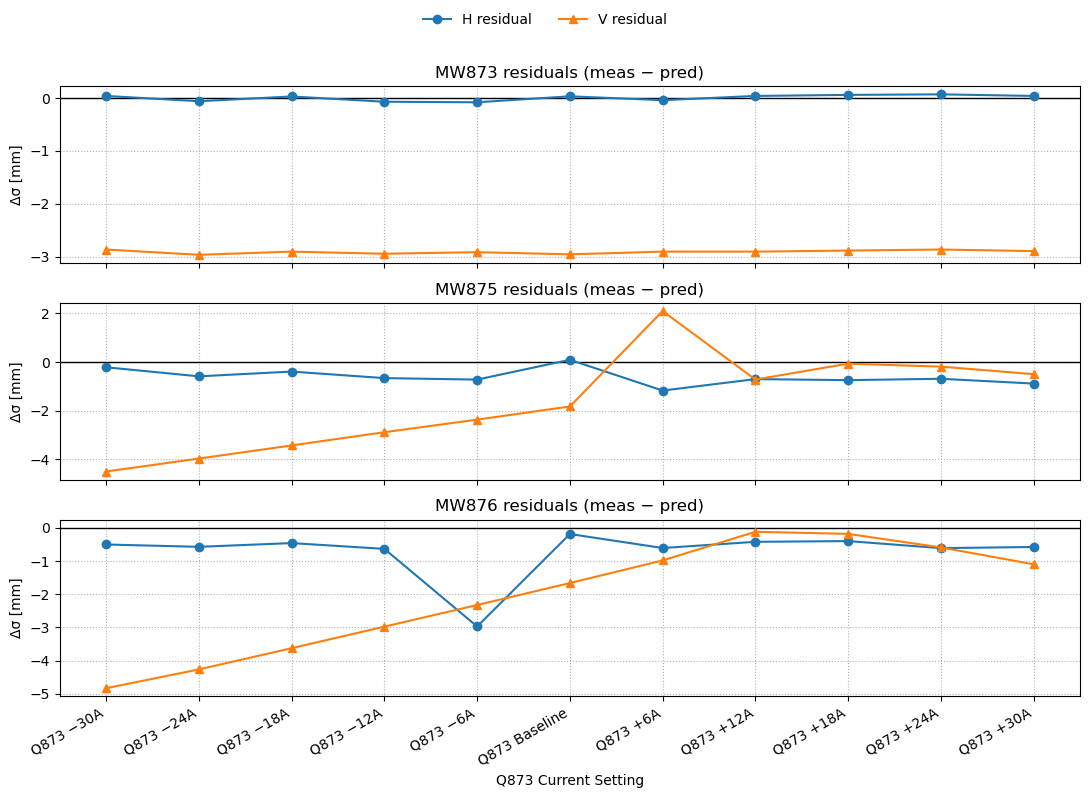

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(11, 8), sharex=True)
for ax, w in zip(axes, ["MW873","MW875","MW876"]):
    resH = np.array(meas_series[(w,"H")]) - np.array(sigma_pred[(w,"H")])
    resV = np.array(meas_series[(w,"V")]) - np.array(sigma_pred[(w,"V")])
    ax.axhline(0.0, color="k", linewidth=1)
    ax.plot(xs, resH, marker="o", linestyle="-",  label="H residual")
    ax.plot(xs, resV, marker="^", linestyle="-",  label="V residual")
    ax.set_title(f"{w} residuals (meas − pred)")
    ax.set_ylabel("Δσ [mm]")
    ax.grid(True, linestyle=":")
axes[-1].set_xticks(xs, xtick_labels, rotation=30, ha="right")
axes[-1].set_xlabel("Q873 Current Setting")
fig.legend(*axes[0].get_legend_handles_labels(), loc="upper center", ncol=4, frameon=False)
fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


Wrote emittance_vs_Q873_current.csv


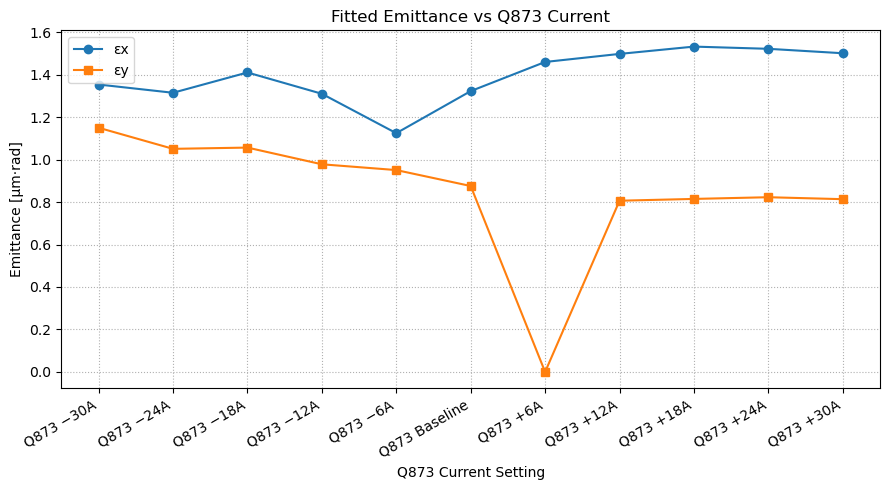

In [9]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Currents & labels
# -------------------------------
order = ["-30","-24","-18","-12","-6","0","+6","+12","+18","+24","+30"]
xlabels = {
    "-30":"Q873 −30A","-24":"Q873 −24A","-18":"Q873 −18A","-12":"Q873 −12A","-6":"Q873 −6A",
    "0":"Q873 Baseline","+6":"Q873 +6A","+12":"Q873 +12A","+18":"Q873 +18A","+24":"Q873 +24A","+30":"Q873 +30A"
}
monitors = ["MW873","MW875","MW876"]

# Prefer flipPol files, fall back to old names
OLD_FILES = {
    "-30": "twiss_Q873_minus30A.tfs",
    "-24": "twiss_Q873_minus24A.tfs",
    "-18": "twiss_Q873_minus18A.tfs",
    "-12": "twiss_Q873_minus12A.tfs",
    "-6" : "twiss_Q873_minus6A.tfs",
    "0"  : "twiss_Q873_default.tfs",
    "+6" : "twiss_Q873_plus6A.tfs",
    "+12": "twiss_Q873_plus12A.tfs",
    "+18": "twiss_Q873_plus18A.tfs",
    "+24": "twiss_Q873_plus24A.tfs",
    "+30": "twiss_Q873_plus30A.tfs",
}
def pick_file_for_current(key):
    if key == "0":
        candidates = ["twiss_Q873_default.tfs"]
    else:
        candidates = [f"twiss_Q873_{key}A_flipPol.tfs", OLD_FILES.get(key,"")]
    for c in candidates:
        if c and os.path.exists(c):
            return c
    return candidates[0]  # will error later if truly missing
files = {k: pick_file_for_current(k) for k in order}

# -------------------------------
# Your measured σ (mm)
# order: [873 H, 873 V, 875 H, 875 V, 876 H, 876 V]
# -------------------------------
meas_data = {
    "Q873 − 30A":    [2.30,  5.05,  3.56,  4.50,  2.29,  4.40],
    "Q873 − 24A":    [2.20,  4.95,  3.40,  3.84,  2.44,  3.60],
    "Q873 − 18A":    [2.29,  5.01,  3.81,  3.20,  2.78,  2.89],
    "Q873 − 12A":    [2.19,  4.97,  3.76,  2.58,  2.84,  2.21],
    "Q873 − 6A":     [2.18,  5.00,  3.92,  1.95,  0.745, 1.56],
    "Q873 Baseline": [2.293, 4.959, 4.957, 1.371, 3.771, 0.9685],
    "Q873 + 6A":     [2.22,  5.01,  3.92,  4.22,  3.60,  0.538],
    "Q873 + 12A":    [2.30,  5.01,  4.62,  0.487, 4.04,  0.950],
    "Q873 + 18A":    [2.32,  5.03,  4.81,  0.918, 4.32,  1.64],
    "Q873 + 24A":    [2.33,  5.05,  5.10,  1.54,  4.37,  2.37],
    "Q873 + 30A":    [2.30,  5.02,  5.14,  2.23,  4.67,  3.07],
}
meas_df = pd.DataFrame.from_dict(
    meas_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

def find_meas_row(label):
    target = label.replace(" ", "")
    for idx in meas_df.index:
        if idx.replace(" ", "") == target:
            return meas_df.loc[idx]
    raise KeyError(f"Measurement row not found for label '{label}'")

# -------------------------------
# TFS reader and MW picker
# -------------------------------
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    header_idx = next(i for i,l in enumerate(lines) if l.lstrip().startswith("*"))
    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if lines[start].lstrip().startswith("$"):
        start += 1
    data_rows = [ln for ln in lines[start:]
                 if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=cols, engine="python")
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            raise RuntimeError(f"{w} not found in TFS")
        out[w] = m.iloc[0]
    return out

# -------------------------------
# LSQ fit per plane at one current:
# solve y = [β, D^2] · [ε, σδ^2]
# -------------------------------
def fit_eps_sdel2(sig_mm_list, beta_list, disp_list):
    # inputs: 3-length lists (wires), sig in mm, beta[m], disp[m]
    y = np.array([(s*1e-3)**2 for s in sig_mm_list])     # m^2
    X = np.column_stack([np.array(beta_list), np.array(disp_list)**2])
    # least squares
    (eps, sdel2), *_ = np.linalg.lstsq(X, y, rcond=None)
    eps = max(eps, 0.0)
    sdel2 = max(sdel2, 0.0)
    return eps, sdel2

# -------------------------------
# Loop over currents and fit H & V
# -------------------------------
results = []  # rows for CSV
epsx_list, epsy_list, sdx_list, sdy_list = [], [], [], []
xs, xtick_labels = [], []

for key in order:
    path = files[key]
    if not os.path.exists(path):
        print(f"Skip {key}: {path} not found")
        continue

    df = read_tfs(path)
    rows = get_mw_rows(df)
    label = xlabels[key]
    meas = find_meas_row(label)

    # Assemble per-wire vectors for H and V
    betx = [float(rows[w]["BETX"]) for w in monitors]
    bety = [float(rows[w]["BETY"]) for w in monitors]
    dx   = [float(rows[w]["DX"])   for w in monitors]
    dy   = [float(rows[w]["DY"])   for w in monitors]

    sigx_mm = [float(meas["873 H"]), float(meas["875 H"]), float(meas["876 H"])]
    sigy_mm = [float(meas["873 V"]), float(meas["875 V"]), float(meas["876 V"])]

    # Fit εx, σδ (H)
    epsx, sdel2x = fit_eps_sdel2(sigx_mm, betx, dx)
    # Fit εy, σδ_y (V) — typically Dy≈0 so sdel2y→0 naturally
    epsy, sdel2y = fit_eps_sdel2(sigy_mm, bety, dy)

    epsx_list.append(epsx)
    epsy_list.append(epsy)
    sdx_list.append(math.sqrt(sdel2x))
    sdy_list.append(math.sqrt(sdel2y))
    xs.append(int(key))
    xtick_labels.append(label)

    results.append({
        "Current": key,
        "Label": label,
        "eps_x [m rad]": epsx,
        "eps_y [m rad]": epsy,
        "sigma_delta_x": math.sqrt(sdel2x),
        "sigma_delta_y": math.sqrt(sdel2y),
    })

# -------------------------------
# Save table
# -------------------------------
res_df = pd.DataFrame(results).set_index("Label")
res_df.to_csv("emittance_vs_Q873_current.csv")
print("Wrote emittance_vs_Q873_current.csv")

# -------------------------------
# Plots
# -------------------------------
xs = np.array(xs)

plt.figure(figsize=(9,5))
plt.plot(xs, np.array(epsx_list)*1e6, marker="o", label="εx")
plt.plot(xs, np.array(epsy_list)*1e6, marker="s", label="εy")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [µm·rad]")
plt.xlabel("Q873 Current Setting")
plt.title("Fitted Emittance vs Q873 Current")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()


Wrote emittance_vs_Q873_current_with_errors.csv


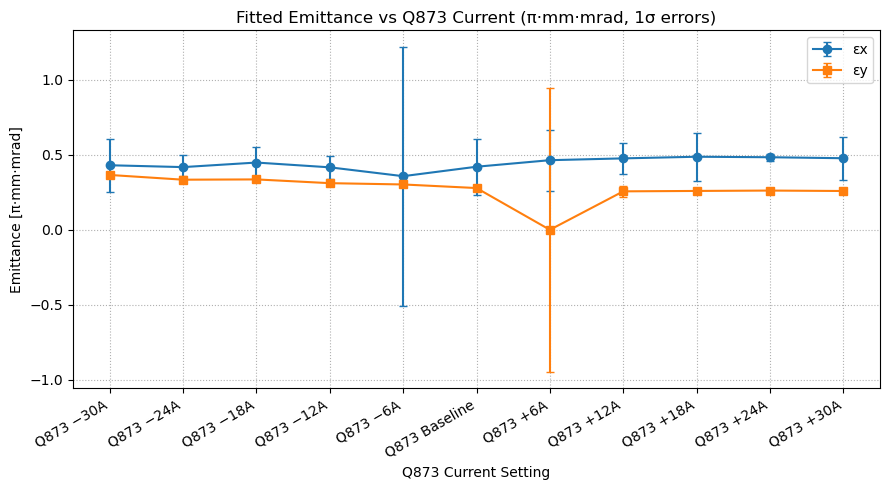

Wrote emittance_vs_Q873_current_pi-mm-mrad.csv


In [10]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================
# Currents, labels, monitors
# =========================================
order = ["-30","-24","-18","-12","-6","0","+6","+12","+18","+24","+30"]
xlabels = {
    "-30":"Q873 −30A","-24":"Q873 −24A","-18":"Q873 −18A","-12":"Q873 −12A","-6":"Q873 −6A",
    "0":"Q873 Baseline","+6":"Q873 +6A","+12":"Q873 +12A","+18":"Q873 +18A","+24":"Q873 +24A","+30":"Q873 +30A"
}
monitors = ["MW873","MW875","MW876"]

# Prefer flipPol files, fall back to old names
OLD_FILES = {
    "-30": "twiss_Q873_minus30A.tfs",
    "-24": "twiss_Q873_minus24A.tfs",
    "-18": "twiss_Q873_minus18A.tfs",
    "-12": "twiss_Q873_minus12A.tfs",
    "-6" : "twiss_Q873_minus6A.tfs",
    "0"  : "twiss_Q873_default.tfs",
    "+6" : "twiss_Q873_plus6A.tfs",
    "+12": "twiss_Q873_plus12A.tfs",
    "+18": "twiss_Q873_plus18A.tfs",
    "+24": "twiss_Q873_plus24A.tfs",
    "+30": "twiss_Q873_plus30A.tfs",
}
def pick_file_for_current(key):
    if key == "0":
        candidates = ["twiss_Q873_default.tfs"]
    else:
        # note '+' in filenames is literal for positive currents
        tag = f"{key}A".replace("+", "+")
        candidates = [f"twiss_Q873_{tag}_flipPol.tfs", OLD_FILES.get(key, "")]
    for c in candidates:
        if c and os.path.exists(c):
            return c
    return candidates[0]  # will error later if truly missing
files = {k: pick_file_for_current(k) for k in order}

# =========================================
# SET MONITOR RESOLUTION HERE (mm)
# (subtracted in quadrature: sigma_corr^2 = sigma_meas^2 - sigma_res^2)
# Give a single number or a dict per wire if needed.
# =========================================
RES_H_MM = 0.00   # horizontal resolution (mm)
RES_V_MM = 0.00   # vertical   resolution (mm)

# Optional: different resolutions per wire (uncomment & use instead)
# RES_H_MM = {"MW873":0.00, "MW875":0.00, "MW876":0.00}
# RES_V_MM = {"MW873":0.00, "MW875":0.00, "MW876":0.00}

def get_res_mm(plane, wire):
    val = RES_H_MM if plane=="H" else RES_V_MM
    if isinstance(val, dict):
        return float(val.get(wire, 0.0))
    return float(val)

# =========================================
# Measured σ (mm) table
# columns: ["873 H","873 V","875 H","875 V","876 H","876 V"]
# =========================================
meas_data = {
    "Q873 − 30A":    [2.30,  5.05,  3.56,  4.50,  2.29,  4.40],
    "Q873 − 24A":    [2.20,  4.95,  3.40,  3.84,  2.44,  3.60],
    "Q873 − 18A":    [2.29,  5.01,  3.81,  3.20,  2.78,  2.89],
    "Q873 − 12A":    [2.19,  4.97,  3.76,  2.58,  2.84,  2.21],
    "Q873 − 6A":     [2.18,  5.00,  3.92,  1.95,  0.745, 1.56],
    "Q873 Baseline": [2.293, 4.959, 4.957, 1.371, 3.771, 0.9685],
    "Q873 + 6A":     [2.22,  5.01,  3.92,  4.22,  3.60,  0.538],
    "Q873 + 12A":    [2.30,  5.01,  4.62,  0.487, 4.04,  0.950],
    "Q873 + 18A":    [2.32,  5.03,  4.81,  0.918, 4.32,  1.64],
    "Q873 + 24A":    [2.33,  5.05,  5.10,  1.54,  4.37,  2.37],
    "Q873 + 30A":    [2.30,  5.02,  5.14,  2.23,  4.67,  3.07],
}
meas_df = pd.DataFrame.from_dict(
    meas_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

def find_meas_row(label):
    target = label.replace(" ", "")
    for idx in meas_df.index:
        if idx.replace(" ", "") == target:
            return meas_df.loc[idx]
    raise KeyError(f"Measurement row not found for label '{label}'")

# =========================================
# TFS reader and MW picker
# =========================================
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    header_idx = next(i for i,l in enumerate(lines) if l.lstrip().startswith("*"))
    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    data_rows = [ln for ln in lines[start:]
                 if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=cols, engine="python")
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            raise RuntimeError(f"{w} not found in TFS")
        out[w] = m.iloc[0]
    return out

# =========================================
# Fitting utilities
# Model: y = X p, where y = sigma^2 (m^2), X = [beta, D^2], p=[eps, sdel^2]
# Uncertainties: Cov(p) = s2 * (X^T X)^(-1), s2 = RSS/(N-p)
# =========================================
def subtract_resolution_mm(sig_mm, res_mm):
    s2 = sig_mm**2 - res_mm**2
    return math.sqrt(s2) if s2 > 0 else 0.0

def fit_two_param(sig_mm_list, beta_list, disp_list):
    # Convert σ(mm) -> σ^2 (m^2) with resolution subtraction
    y = []
    for s_mm in sig_mm_list:
        y.append((s_mm*1e-3)**2)
    y = np.array(y)

    X = np.column_stack([np.array(beta_list, float),
                         np.array(disp_list, float)**2])

    # Solve and uncertainties
    p, *_ = np.linalg.lstsq(X, y, rcond=None)
    eps, sdel2 = float(p[0]), float(p[1])

    # residuals and covariance
    r = y - X @ p
    N, P = X.shape[0], X.shape[1]
    dof = max(N - P, 1)
    rss = float(r.T @ r)
    s2 = rss / dof
    try:
        cov = s2 * np.linalg.inv(X.T @ X)
        std = np.sqrt(np.diag(cov))
        eps_std, sdel2_std = float(std[0]), float(std[1])
    except np.linalg.LinAlgError:
        eps_std, sdel2_std = float("nan"), float("nan")

    return max(eps,0.0), max(sdel2,0.0), eps_std, sdel2_std

def fit_one_param(sig_mm_list, beta_list):
    # y = eps*beta; uncertainties: Var(eps) = s2 / (sum beta^2)
    y = np.array([(s*1e-3)**2 for s in sig_mm_list], float)
    X = np.array(beta_list, float).reshape(-1,1)
    # analytic LSQ
    denom = float((X.T @ X)[0,0])
    eps = float((X.T @ y)[0]) / denom if denom > 0 else 0.0
    r = y - X.flatten()*eps
    dof = max(len(y) - 1, 1)
    rss = float(r.T @ r)
    s2 = rss / dof
    eps_std = math.sqrt(s2/denom) if denom > 0 else float("nan")
    return max(eps,0.0), eps_std

# Heuristic: if DY is tiny or the 2-param matrix is ill-conditioned, use 1-param in V
COND_THRESH = 1e10
DY_THRESH   = 1e-3  # [m]

# =========================================
# Loop over currents, subtract resolution, fit
# =========================================
rows_out = []
xs, xtick_labels = [], []
epsx, epsx_std, epsy, epsy_std = [], [], [], []
sdx, sdx_std, sdy, sdy_std     = [], [], [], []

for key in order:
    path = files[key]
    if not os.path.exists(path):
        print(f"Skip {key}: {path} not found")
        continue

    df = read_tfs(path)
    rows = get_mw_rows(df)
    label = xlabels[key]
    meas = find_meas_row(label)

    # Assemble per-wire lists
    betx = [float(rows[w]["BETX"]) for w in monitors]
    bety = [float(rows[w]["BETY"]) for w in monitors]
    dx   = [float(rows[w]["DX"])   for w in monitors]
    dy   = [float(rows[w]["DY"])   for w in monitors]

    # Measured sigmas with resolution subtraction (per plane and wire)
    sigx_mm = []
    sigy_mm = []
    for w, short in zip(monitors, ["873","875","876"]):
        sx = float(meas[f"{short} H"])
        sy = float(meas[f"{short} V"])
        sigx_mm.append(subtract_resolution_mm(sx, get_res_mm("H", w)))
        sigy_mm.append(subtract_resolution_mm(sy, get_res_mm("V", w)))

    # --- Horizontal: 2-parameter fit (β, D^2)
    ex, sdx2, ex_std, sdx2_std = fit_two_param(sigx_mm, betx, dx)
    sdx_val   = math.sqrt(sdx2)
    sdx_stdev = 0.5*sdx2_std/math.sqrt(sdx2) if sdx2 > 0 and np.isfinite(sdx2_std) else float("nan")

    # --- Vertical: try 2-param; fallback to 1-param if ill-conditioned or tiny DY
    use_one_param_v = (max(abs(v) for v in dy) < DY_THRESH)
    if not use_one_param_v:
        # check condition number
        Xv = np.column_stack([np.array(bety, float), np.array(dy, float)**2])
        try:
            cond = np.linalg.cond(Xv)
            use_one_param_v = cond > COND_THRESH
        except np.linalg.LinAlgError:
            use_one_param_v = True

    if use_one_param_v:
        ey, ey_std = fit_one_param(sigy_mm, bety)
        sdy_val, sdy_stdev = 0.0, 0.0
    else:
        ey, sdy2, ey_std, sdy2_std = fit_two_param(sigy_mm, bety, dy)
        sdy_val   = math.sqrt(sdy2)
        sdy_stdev = 0.5*sdy2_std/math.sqrt(sdy2) if sdy2 > 0 and np.isfinite(sdy2_std) else float("nan")

    # Collect
    xs.append(int(key))
    xtick_labels.append(label)
    epsx.append(ex); epsx_std.append(ex_std)
    epsy.append(ey); epsy_std.append(ey_std)
    sdx.append(sdx_val); sdx_std.append(sdx_stdev)
    sdy.append(sdy_val); sdy_std.append(sdy_stdev)

    rows_out.append({
        "Current": key, "Label": label,
        "eps_x [m rad]": ex,  "eps_x_std [m rad]": ex_std,
        "eps_y [m rad]": ey,  "eps_y_std [m rad]": ey_std,
        "sigma_delta_x": sdx_val, "sigma_delta_x_std": sdx_stdev,
        "sigma_delta_y": sdy_val, "sigma_delta_y_std": sdy_stdev,
        "fit_mode_y": "1-param (Dy≈0)" if use_one_param_v else "2-param",
    })

# =========================================
# Save CSV
# =========================================
res_df = pd.DataFrame(rows_out).set_index("Label")
res_df.to_csv("emittance_vs_Q873_current_with_errors.csv")
print("Wrote emittance_vs_Q873_current_with_errors.csv")

# =========================================
# Plots with error bars
# =========================================
xs = np.array(xs)

# ===== Emittance plots & CSV in π·mm·mrad =====
scale_pi_mm_mrad = 1e6 / math.pi  # m·rad -> π·mm·mrad

epsx_pi   = np.array(epsx)     * scale_pi_mm_mrad
epsy_pi   = np.array(epsy)     * scale_pi_mm_mrad
epsx_pi_e = np.array(epsx_std) * scale_pi_mm_mrad
epsy_pi_e = np.array(epsy_std) * scale_pi_mm_mrad

plt.figure(figsize=(9,5))
plt.errorbar(xs, epsx_pi, yerr=epsx_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx")
plt.errorbar(xs, epsy_pi, yerr=epsy_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [π·mm·mrad]")
plt.xlabel("Q873 Current Setting")
plt.title("Fitted Emittance vs Q873 Current (π·mm·mrad, 1σ errors)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# Save a CSV in π·mm·mrad as well
emi_out = pd.DataFrame({
    "eps_x [π·mm·mrad]": epsx_pi,
    "eps_x_std [π·mm·mrad]": epsx_pi_e,
    "eps_y [π·mm·mrad]": epsy_pi,
    "eps_y_std [π·mm·mrad]": epsy_pi_e,
}, index=xtick_labels)
emi_out.to_csv("emittance_vs_Q873_current_pi-mm-mrad.csv")
print("Wrote emittance_vs_Q873_current_pi-mm-mrad.csv")


Wrote emittance_vs_Q873_current_with_errors.csv


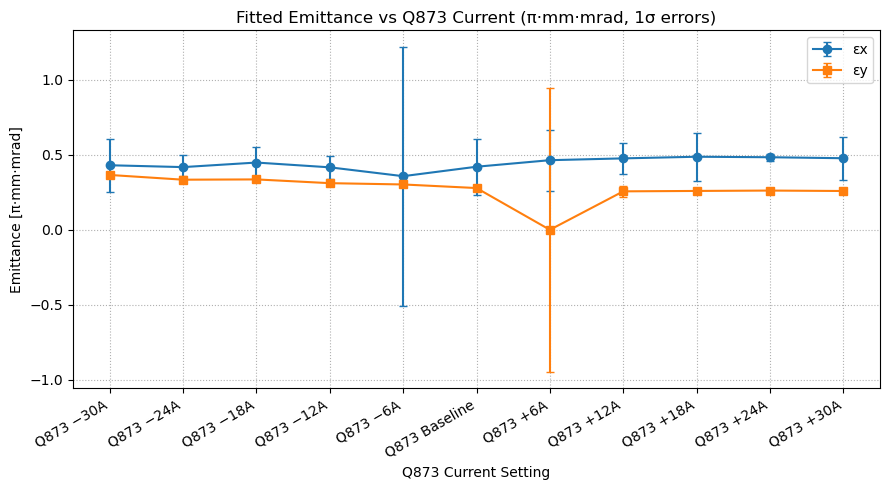

Wrote emittance_vs_Q873_current_pi-mm-mrad.csv


In [11]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================
# Currents, labels, monitors
# =========================================
order = ["-30","-24","-18","-12","-6","0","+6","+12","+18","+24","+30"]
xlabels = {
    "-30":"Q873 −30A","-24":"Q873 −24A","-18":"Q873 −18A","-12":"Q873 −12A","-6":"Q873 −6A",
    "0":"Q873 Baseline","+6":"Q873 +6A","+12":"Q873 +12A","+18":"Q873 +18A","+24":"Q873 +24A","+30":"Q873 +30A"
}
monitors = ["MW873","MW875","MW876"]

# Prefer flipPol files, fall back to old names
OLD_FILES = {
    "-30": "twiss_Q873_minus30A.tfs",
    "-24": "twiss_Q873_minus24A.tfs",
    "-18": "twiss_Q873_minus18A.tfs",
    "-12": "twiss_Q873_minus12A.tfs",
    "-6" : "twiss_Q873_minus6A.tfs",
    "0"  : "twiss_Q873_default.tfs",
    "+6" : "twiss_Q873_plus6A.tfs",
    "+12": "twiss_Q873_plus12A.tfs",
    "+18": "twiss_Q873_plus18A.tfs",
    "+24": "twiss_Q873_plus24A.tfs",
    "+30": "twiss_Q873_plus30A.tfs",
}
def pick_file_for_current(key):
    if key == "0":
        candidates = ["twiss_Q873_default.tfs"]
    else:
        # note '+' in filenames is literal for positive currents
        tag = f"{key}A".replace("+", "+")
        candidates = [f"twiss_Q873_{tag}_flipPol.tfs", OLD_FILES.get(key, "")]
    for c in candidates:
        if c and os.path.exists(c):
            return c
    return candidates[0]  # will error later if truly missing
files = {k: pick_file_for_current(k) for k in order}

# =========================================
# SET MONITOR RESOLUTION HERE (mm)
# (subtracted in quadrature: sigma_corr^2 = sigma_meas^2 - sigma_res^2)
# Give a single number or a dict per wire if needed.
# =========================================
RES_H_MM = 0.00   # horizontal resolution (mm)
RES_V_MM = 0.00   # vertical   resolution (mm)

# Optional: different resolutions per wire (uncomment & use instead)
# RES_H_MM = {"MW873":0.00, "MW875":0.00, "MW876":0.00}
# RES_V_MM = {"MW873":0.00, "MW875":0.00, "MW876":0.00}

def get_res_mm(plane, wire):
    val = RES_H_MM if plane=="H" else RES_V_MM
    if isinstance(val, dict):
        return float(val.get(wire, 0.0))
    return float(val)

# =========================================
# Measured σ (mm) table
# columns: ["873 H","873 V","875 H","875 V","876 H","876 V"]
# =========================================
meas_data = {
    "Q873 − 30A":    [2.30,  5.05,  3.56,  4.50,  2.29,  4.40],
    "Q873 − 24A":    [2.20,  4.95,  3.40,  3.84,  2.44,  3.60],
    "Q873 − 18A":    [2.29,  5.01,  3.81,  3.20,  2.78,  2.89],
    "Q873 − 12A":    [2.19,  4.97,  3.76,  2.58,  2.84,  2.21],
    "Q873 − 6A":     [2.18,  5.00,  3.92,  1.95,  0.745, 1.56],
    "Q873 Baseline": [2.293, 4.959, 4.957, 1.371, 3.771, 0.9685],
    "Q873 + 6A":     [2.22,  5.01,  3.92,  4.22,  3.60,  0.538],
    "Q873 + 12A":    [2.30,  5.01,  4.62,  0.487, 4.04,  0.950],
    "Q873 + 18A":    [2.32,  5.03,  4.81,  0.918, 4.32,  1.64],
    "Q873 + 24A":    [2.33,  5.05,  5.10,  1.54,  4.37,  2.37],
    "Q873 + 30A":    [2.30,  5.02,  5.14,  2.23,  4.67,  3.07],
}
meas_df = pd.DataFrame.from_dict(
    meas_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

def find_meas_row(label):
    target = label.replace(" ", "")
    for idx in meas_df.index:
        if idx.replace(" ", "") == target:
            return meas_df.loc[idx]
    raise KeyError(f"Measurement row not found for label '{label}'")

# =========================================
# TFS reader and MW picker
# =========================================
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    header_idx = next(i for i,l in enumerate(lines) if l.lstrip().startswith("*"))
    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    data_rows = [ln for ln in lines[start:]
                 if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=cols, engine="python")
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            raise RuntimeError(f"{w} not found in TFS")
        out[w] = m.iloc[0]
    return out

# =========================================
# Fitting utilities
# Model: y = X p, where y = sigma^2 (m^2), X = [beta, D^2], p=[eps, sdel^2]
# Uncertainties: Cov(p) = s2 * (X^T X)^(-1), s2 = RSS/(N-p)
# =========================================
def subtract_resolution_mm(sig_mm, res_mm):
    s2 = sig_mm**2 - res_mm**2
    return math.sqrt(s2) if s2 > 0 else 0.0

def fit_two_param(sig_mm_list, beta_list, disp_list):
    # Convert σ(mm) -> σ^2 (m^2) with resolution subtraction
    y = []
    for s_mm in sig_mm_list:
        y.append((s_mm*1e-3)**2)
    y = np.array(y)

    X = np.column_stack([np.array(beta_list, float),
                         np.array(disp_list, float)**2])

    # Solve and uncertainties
    p, *_ = np.linalg.lstsq(X, y, rcond=None)
    eps, sdel2 = float(p[0]), float(p[1])

    # residuals and covariance
    r = y - X @ p
    N, P = X.shape[0], X.shape[1]
    dof = max(N - P, 1)
    rss = float(r.T @ r)
    s2 = rss / dof
    try:
        cov = s2 * np.linalg.inv(X.T @ X)
        std = np.sqrt(np.diag(cov))
        eps_std, sdel2_std = float(std[0]), float(std[1])
    except np.linalg.LinAlgError:
        eps_std, sdel2_std = float("nan"), float("nan")

    return max(eps,0.0), max(sdel2,0.0), eps_std, sdel2_std

def fit_one_param(sig_mm_list, beta_list):
    # y = eps*beta; uncertainties: Var(eps) = s2 / (sum beta^2)
    y = np.array([(s*1e-3)**2 for s in sig_mm_list], float)
    X = np.array(beta_list, float).reshape(-1,1)
    # analytic LSQ
    denom = float((X.T @ X)[0,0])
    eps = float((X.T @ y)[0]) / denom if denom > 0 else 0.0
    r = y - X.flatten()*eps
    dof = max(len(y) - 1, 1)
    rss = float(r.T @ r)
    s2 = rss / dof
    eps_std = math.sqrt(s2/denom) if denom > 0 else float("nan")
    return max(eps,0.0), eps_std

# Heuristic: if DY is tiny or the 2-param matrix is ill-conditioned, use 1-param in V
COND_THRESH = 1e10
DY_THRESH   = 1e-3  # [m]

# =========================================
# Loop over currents, subtract resolution, fit
# =========================================
rows_out = []
xs, xtick_labels = [], []
epsx, epsx_std, epsy, epsy_std = [], [], [], []
sdx, sdx_std, sdy, sdy_std     = [], [], [], []

for key in order:
    path = files[key]
    if not os.path.exists(path):
        print(f"Skip {key}: {path} not found")
        continue

    df = read_tfs(path)
    rows = get_mw_rows(df)
    label = xlabels[key]
    meas = find_meas_row(label)

    # Assemble per-wire lists
    betx = [float(rows[w]["BETX"]) for w in monitors]
    bety = [float(rows[w]["BETY"]) for w in monitors]
    dx   = [float(rows[w]["DX"])   for w in monitors]
    dy   = [float(rows[w]["DY"])   for w in monitors]

    # Measured sigmas with resolution subtraction (per plane and wire)
    sigx_mm = []
    sigy_mm = []
    for w, short in zip(monitors, ["873","875","876"]):
        sx = float(meas[f"{short} H"])
        sy = float(meas[f"{short} V"])
        sigx_mm.append(subtract_resolution_mm(sx, get_res_mm("H", w)))
        sigy_mm.append(subtract_resolution_mm(sy, get_res_mm("V", w)))

    # --- Horizontal: 2-parameter fit (β, D^2)
    ex, sdx2, ex_std, sdx2_std = fit_two_param(sigx_mm, betx, dx)
    sdx_val   = math.sqrt(sdx2)
    sdx_stdev = 0.5*sdx2_std/math.sqrt(sdx2) if sdx2 > 0 and np.isfinite(sdx2_std) else float("nan")

    # --- Vertical: try 2-param; fallback to 1-param if ill-conditioned or tiny DY
    use_one_param_v = (max(abs(v) for v in dy) < DY_THRESH)
    if not use_one_param_v:
        # check condition number
        Xv = np.column_stack([np.array(bety, float), np.array(dy, float)**2])
        try:
            cond = np.linalg.cond(Xv)
            use_one_param_v = cond > COND_THRESH
        except np.linalg.LinAlgError:
            use_one_param_v = True

    if use_one_param_v:
        ey, ey_std = fit_one_param(sigy_mm, bety)
        sdy_val, sdy_stdev = 0.0, 0.0
    else:
        ey, sdy2, ey_std, sdy2_std = fit_two_param(sigy_mm, bety, dy)
        sdy_val   = math.sqrt(sdy2)
        sdy_stdev = 0.5*sdy2_std/math.sqrt(sdy2) if sdy2 > 0 and np.isfinite(sdy2_std) else float("nan")

    # Collect
    xs.append(int(key))
    xtick_labels.append(label)
    epsx.append(ex); epsx_std.append(ex_std)
    epsy.append(ey); epsy_std.append(ey_std)
    sdx.append(sdx_val); sdx_std.append(sdx_stdev)
    sdy.append(sdy_val); sdy_std.append(sdy_stdev)

    rows_out.append({
        "Current": key, "Label": label,
        "eps_x [m rad]": ex,  "eps_x_std [m rad]": ex_std,
        "eps_y [m rad]": ey,  "eps_y_std [m rad]": ey_std,
        "sigma_delta_x": sdx_val, "sigma_delta_x_std": sdx_stdev,
        "sigma_delta_y": sdy_val, "sigma_delta_y_std": sdy_stdev,
        "fit_mode_y": "1-param (Dy≈0)" if use_one_param_v else "2-param",
    })

# =========================================
# Save CSV
# =========================================
res_df = pd.DataFrame(rows_out).set_index("Label")
res_df.to_csv("emittance_vs_Q873_current_with_errors.csv")
print("Wrote emittance_vs_Q873_current_with_errors.csv")

# =========================================
# Plots with error bars
# =========================================
xs = np.array(xs)

# ===== Emittance plots & CSV in π·mm·mrad =====
scale_pi_mm_mrad = 1e6 / math.pi  # m·rad -> π·mm·mrad

epsx_pi   = np.array(epsx)     * scale_pi_mm_mrad
epsy_pi   = np.array(epsy)     * scale_pi_mm_mrad
epsx_pi_e = np.array(epsx_std) * scale_pi_mm_mrad
epsy_pi_e = np.array(epsy_std) * scale_pi_mm_mrad

plt.figure(figsize=(9,5))
plt.errorbar(xs, epsx_pi, yerr=epsx_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx")
plt.errorbar(xs, epsy_pi, yerr=epsy_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [π·mm·mrad]")
plt.xlabel("Q873 Current Setting")
plt.title("Fitted Emittance vs Q873 Current (π·mm·mrad, 1σ errors)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# Save a CSV in π·mm·mrad as well
emi_out = pd.DataFrame({
    "eps_x [π·mm·mrad]": epsx_pi,
    "eps_x_std [π·mm·mrad]": epsx_pi_e,
    "eps_y [π·mm·mrad]": epsy_pi,
    "eps_y_std [π·mm·mrad]": epsy_pi_e,
}, index=xtick_labels)
emi_out.to_csv("emittance_vs_Q873_current_pi-mm-mrad.csv")
print("Wrote emittance_vs_Q873_current_pi-mm-mrad.csv")


Wrote emittance_vs_Q873_current_with_errors.csv


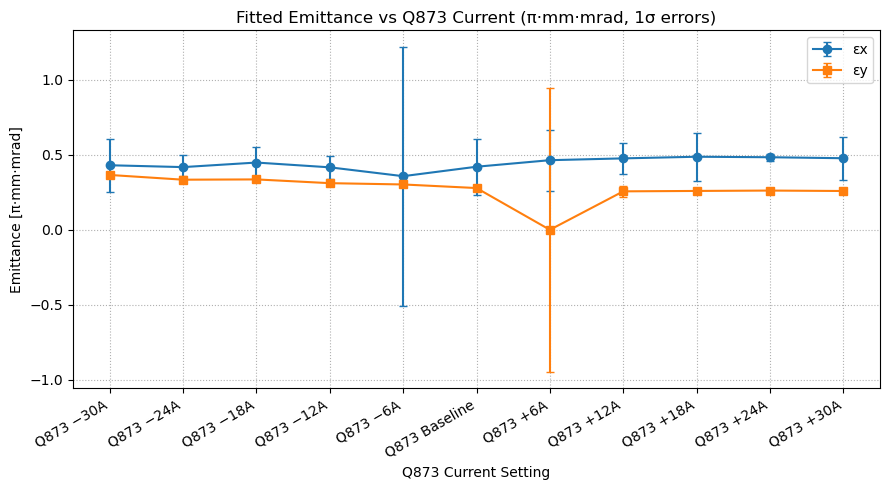

Wrote emittance_vs_Q873_current_pi-mm-mrad.csv


In [12]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================
# Currents, labels, monitors
# =========================================
order = ["-30","-24","-18","-12","-6","0","+6","+12","+18","+24","+30"]
xlabels = {
    "-30":"Q873 −30A","-24":"Q873 −24A","-18":"Q873 −18A","-12":"Q873 −12A","-6":"Q873 −6A",
    "0":"Q873 Baseline","+6":"Q873 +6A","+12":"Q873 +12A","+18":"Q873 +18A","+24":"Q873 +24A","+30":"Q873 +30A"
}
monitors = ["MW873","MW875","MW876"]

# Prefer flipPol files, fall back to old names
OLD_FILES = {
    "-30": "twiss_Q873_minus30A.tfs",
    "-24": "twiss_Q873_minus24A.tfs",
    "-18": "twiss_Q873_minus18A.tfs",
    "-12": "twiss_Q873_minus12A.tfs",
    "-6" : "twiss_Q873_minus6A.tfs",
    "0"  : "twiss_Q873_default.tfs",
    "+6" : "twiss_Q873_plus6A.tfs",
    "+12": "twiss_Q873_plus12A.tfs",
    "+18": "twiss_Q873_plus18A.tfs",
    "+24": "twiss_Q873_plus24A.tfs",
    "+30": "twiss_Q873_plus30A.tfs",
}
def pick_file_for_current(key):
    if key == "0":
        candidates = ["twiss_Q873_default.tfs"]
    else:
        # note '+' in filenames is literal for positive currents
        tag = f"{key}A".replace("+", "+")
        candidates = [f"twiss_Q873_{tag}_flipPol.tfs", OLD_FILES.get(key, "")]
    for c in candidates:
        if c and os.path.exists(c):
            return c
    return candidates[0]  # will error later if truly missing
files = {k: pick_file_for_current(k) for k in order}

# =========================================
# SET MONITOR RESOLUTION HERE (mm)
# (subtracted in quadrature: sigma_corr^2 = sigma_meas^2 - sigma_res^2)
# Give a single number or a dict per wire if needed.
# =========================================
RES_H_MM = 0.00   # horizontal resolution (mm)
RES_V_MM = 0.00   # vertical   resolution (mm)

# Optional: different resolutions per wire (uncomment & use instead)
# RES_H_MM = {"MW873":0.00, "MW875":0.00, "MW876":0.00}
# RES_V_MM = {"MW873":0.00, "MW875":0.00, "MW876":0.00}

def get_res_mm(plane, wire):
    val = RES_H_MM if plane=="H" else RES_V_MM
    if isinstance(val, dict):
        return float(val.get(wire, 0.0))
    return float(val)

# =========================================
# Your measured σ (mm) table
# columns: ["873 H","873 V","875 H","875 V","876 H","876 V"]
# =========================================
meas_data = {
    "Q873 − 30A":    [2.30,  5.05,  3.56,  4.50,  2.29,  4.40],
    "Q873 − 24A":    [2.20,  4.95,  3.40,  3.84,  2.44,  3.60],
    "Q873 − 18A":    [2.29,  5.01,  3.81,  3.20,  2.78,  2.89],
    "Q873 − 12A":    [2.19,  4.97,  3.76,  2.58,  2.84,  2.21],
    "Q873 − 6A":     [2.18,  5.00,  3.92,  1.95,  0.745, 1.56],
    "Q873 Baseline": [2.293, 4.959, 4.957, 1.371, 3.771, 0.9685],
    "Q873 + 6A":     [2.22,  5.01,  3.92,  4.22,  3.60,  0.538],
    "Q873 + 12A":    [2.30,  5.01,  4.62,  0.487, 4.04,  0.950],
    "Q873 + 18A":    [2.32,  5.03,  4.81,  0.918, 4.32,  1.64],
    "Q873 + 24A":    [2.33,  5.05,  5.10,  1.54,  4.37,  2.37],
    "Q873 + 30A":    [2.30,  5.02,  5.14,  2.23,  4.67,  3.07],
}
meas_df = pd.DataFrame.from_dict(
    meas_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

def find_meas_row(label):
    target = label.replace(" ", "")
    for idx in meas_df.index:
        if idx.replace(" ", "") == target:
            return meas_df.loc[idx]
    raise KeyError(f"Measurement row not found for label '{label}'")

# =========================================
# TFS reader and MW picker
# =========================================
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    header_idx = next(i for i,l in enumerate(lines) if l.lstrip().startswith("*"))
    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    data_rows = [ln for ln in lines[start:]
                 if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=cols, engine="python")
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            raise RuntimeError(f"{w} not found in TFS")
        out[w] = m.iloc[0]
    return out

# =========================================
# Fitting utilities
# Model: y = X p, where y = sigma^2 (m^2), X = [beta, D^2], p=[eps, sdel^2]
# Uncertainties: Cov(p) = s2 * (X^T X)^(-1), s2 = RSS/(N-p)
# =========================================
def subtract_resolution_mm(sig_mm, res_mm):
    s2 = sig_mm**2 - res_mm**2
    return math.sqrt(s2) if s2 > 0 else 0.0

def fit_two_param(sig_mm_list, beta_list, disp_list):
    # Convert σ(mm) -> σ^2 (m^2) with resolution subtraction
    y = []
    for s_mm in sig_mm_list:
        y.append((s_mm*1e-3)**2)
    y = np.array(y)

    X = np.column_stack([np.array(beta_list, float),
                         np.array(disp_list, float)**2])

    # Solve and uncertainties
    p, *_ = np.linalg.lstsq(X, y, rcond=None)
    eps, sdel2 = float(p[0]), float(p[1])

    # residuals and covariance
    r = y - X @ p
    N, P = X.shape[0], X.shape[1]
    dof = max(N - P, 1)
    rss = float(r.T @ r)
    s2 = rss / dof
    try:
        cov = s2 * np.linalg.inv(X.T @ X)
        std = np.sqrt(np.diag(cov))
        eps_std, sdel2_std = float(std[0]), float(std[1])
    except np.linalg.LinAlgError:
        eps_std, sdel2_std = float("nan"), float("nan")

    return max(eps,0.0), max(sdel2,0.0), eps_std, sdel2_std

def fit_one_param(sig_mm_list, beta_list):
    # y = eps*beta; uncertainties: Var(eps) = s2 / (sum beta^2)
    y = np.array([(s*1e-3)**2 for s in sig_mm_list], float)
    X = np.array(beta_list, float).reshape(-1,1)
    # analytic LSQ
    denom = float((X.T @ X)[0,0])
    eps = float((X.T @ y)[0]) / denom if denom > 0 else 0.0
    r = y - X.flatten()*eps
    dof = max(len(y) - 1, 1)
    rss = float(r.T @ r)
    s2 = rss / dof
    eps_std = math.sqrt(s2/denom) if denom > 0 else float("nan")
    return max(eps,0.0), eps_std

# Heuristic: if DY is tiny or the 2-param matrix is ill-conditioned, use 1-param in V
COND_THRESH = 1e10
DY_THRESH   = 1e-3  # [m]

# =========================================
# Loop over currents, subtract resolution, fit
# =========================================
rows_out = []
xs, xtick_labels = [], []
epsx, epsx_std, epsy, epsy_std = [], [], [], []
sdx, sdx_std, sdy, sdy_std     = [], [], [], []

for key in order:
    path = files[key]
    if not os.path.exists(path):
        print(f"Skip {key}: {path} not found")
        continue

    df = read_tfs(path)
    rows = get_mw_rows(df)
    label = xlabels[key]
    meas = find_meas_row(label)

    # Assemble per-wire lists
    betx = [float(rows[w]["BETX"]) for w in monitors]
    bety = [float(rows[w]["BETY"]) for w in monitors]
    dx   = [float(rows[w]["DX"])   for w in monitors]
    dy   = [float(rows[w]["DY"])   for w in monitors]

    # Measured sigmas with resolution subtraction (per plane and wire)
    sigx_mm = []
    sigy_mm = []
    for w, short in zip(monitors, ["873","875","876"]):
        sx = float(meas[f"{short} H"])
        sy = float(meas[f"{short} V"])
        sigx_mm.append(subtract_resolution_mm(sx, get_res_mm("H", w)))
        sigy_mm.append(subtract_resolution_mm(sy, get_res_mm("V", w)))

    # --- Horizontal: 2-parameter fit (β, D^2)
    ex, sdx2, ex_std, sdx2_std = fit_two_param(sigx_mm, betx, dx)
    sdx_val   = math.sqrt(sdx2)
    sdx_stdev = 0.5*sdx2_std/math.sqrt(sdx2) if sdx2 > 0 and np.isfinite(sdx2_std) else float("nan")

    # --- Vertical: try 2-param; fallback to 1-param if ill-conditioned or tiny DY
    use_one_param_v = (max(abs(v) for v in dy) < DY_THRESH)
    if not use_one_param_v:
        # check condition number
        Xv = np.column_stack([np.array(bety, float), np.array(dy, float)**2])
        try:
            cond = np.linalg.cond(Xv)
            use_one_param_v = cond > COND_THRESH
        except np.linalg.LinAlgError:
            use_one_param_v = True

    if use_one_param_v:
        ey, ey_std = fit_one_param(sigy_mm, bety)
        sdy_val, sdy_stdev = 0.0, 0.0
    else:
        ey, sdy2, ey_std, sdy2_std = fit_two_param(sigy_mm, bety, dy)
        sdy_val   = math.sqrt(sdy2)
        sdy_stdev = 0.5*sdy2_std/math.sqrt(sdy2) if sdy2 > 0 and np.isfinite(sdy2_std) else float("nan")

    # Collect
    xs.append(int(key))
    xtick_labels.append(label)
    epsx.append(ex); epsx_std.append(ex_std)
    epsy.append(ey); epsy_std.append(ey_std)
    sdx.append(sdx_val); sdx_std.append(sdx_stdev)
    sdy.append(sdy_val); sdy_std.append(sdy_stdev)

    rows_out.append({
        "Current": key, "Label": label,
        "eps_x [m rad]": ex,  "eps_x_std [m rad]": ex_std,
        "eps_y [m rad]": ey,  "eps_y_std [m rad]": ey_std,
        "sigma_delta_x": sdx_val, "sigma_delta_x_std": sdx_stdev,
        "sigma_delta_y": sdy_val, "sigma_delta_y_std": sdy_stdev,
        "fit_mode_y": "1-param (Dy≈0)" if use_one_param_v else "2-param",
    })

# =========================================
# Save CSV
# =========================================
res_df = pd.DataFrame(rows_out).set_index("Label")
res_df.to_csv("emittance_vs_Q873_current_with_errors.csv")
print("Wrote emittance_vs_Q873_current_with_errors.csv")

# =========================================
# Plots with error bars
# =========================================
xs = np.array(xs)

# ===== Emittance plots & CSV in π·mm·mrad =====
scale_pi_mm_mrad = 1e6 / math.pi  # m·rad -> π·mm·mrad

epsx_pi   = np.array(epsx)     * scale_pi_mm_mrad
epsy_pi   = np.array(epsy)     * scale_pi_mm_mrad
epsx_pi_e = np.array(epsx_std) * scale_pi_mm_mrad
epsy_pi_e = np.array(epsy_std) * scale_pi_mm_mrad

plt.figure(figsize=(9,5))
plt.errorbar(xs, epsx_pi, yerr=epsx_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx")
plt.errorbar(xs, epsy_pi, yerr=epsy_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [π·mm·mrad]")
plt.xlabel("Q873 Current Setting")
plt.title("Fitted Emittance vs Q873 Current (π·mm·mrad, 1σ errors)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# Save a CSV in π·mm·mrad as well
emi_out = pd.DataFrame({
    "eps_x [π·mm·mrad]": epsx_pi,
    "eps_x_std [π·mm·mrad]": epsx_pi_e,
    "eps_y [π·mm·mrad]": epsy_pi,
    "eps_y_std [π·mm·mrad]": epsy_pi_e,
}, index=xtick_labels)
emi_out.to_csv("emittance_vs_Q873_current_pi-mm-mrad.csv")
print("Wrote emittance_vs_Q873_current_pi-mm-mrad.csv")


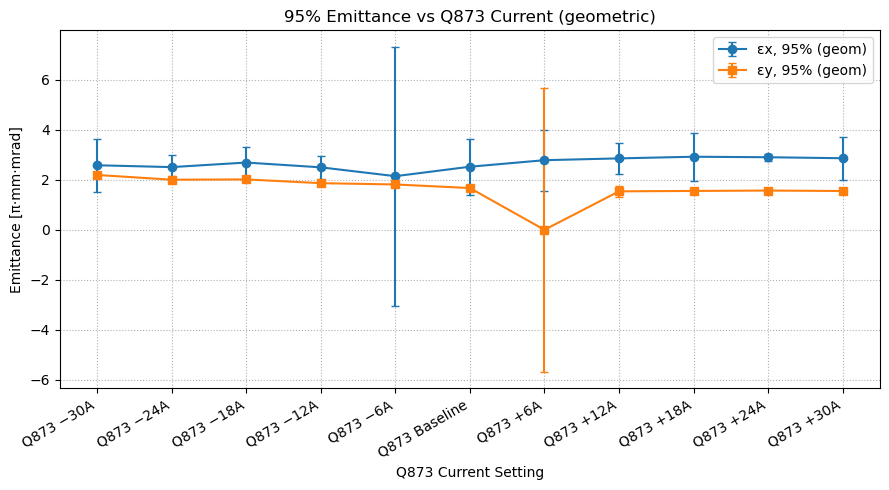

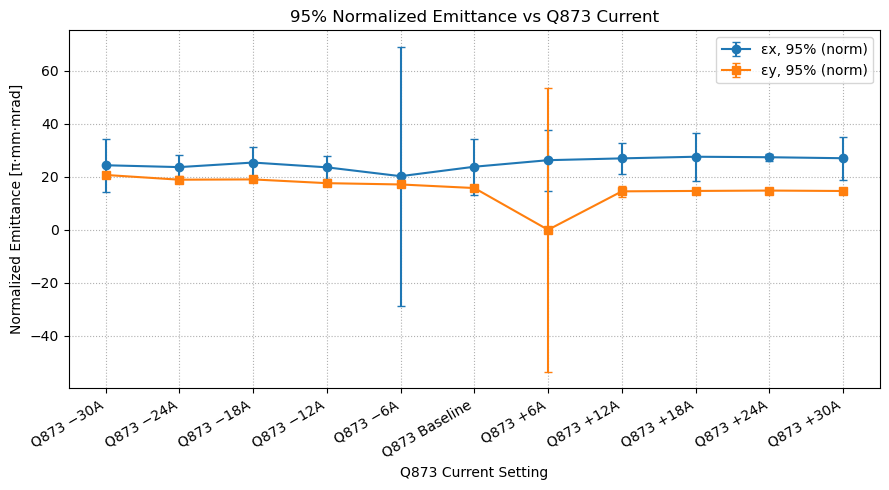

Wrote emittance95_geometric_pi-mm-mrad.csv and emittance95_normalized_pi-mm-mrad.csv


In [13]:
# ---- 95% emittance from rms results ----
F95 = 6.0                       # 95% ≈ 6 × rms (Gaussian FNAL convention)
scale_pi_mm_mrad = 1e6 / math.pi  # m·rad -> π·mm·mrad

# geometric 95% in π·mm·mrad
epsx95_pi   = F95 * np.array(epsx)     * scale_pi_mm_mrad
epsy95_pi   = F95 * np.array(epsy)     * scale_pi_mm_mrad
epsx95_pi_e = F95 * np.array(epsx_std) * scale_pi_mm_mrad
epsy95_pi_e = F95 * np.array(epsy_std) * scale_pi_mm_mrad

# (optional) normalized 95% in π·mm·mrad
p_GeV = 8.83490
m_GeV = 0.9382720813
bg = p_GeV / m_GeV          # βγ ≈ 9.41 at 8.8349 GeV/c
epsx95n_pi   = epsx95_pi   * bg
epsy95n_pi   = epsy95_pi   * bg
epsx95n_pi_e = epsx95_pi_e * bg
epsy95n_pi_e = epsy95_pi_e * bg

# ---- Plot geometric 95% ----
plt.figure(figsize=(9,5))
plt.errorbar(xs, epsx95_pi, yerr=epsx95_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx, 95% (geom)")
plt.errorbar(xs, epsy95_pi, yerr=epsy95_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy, 95% (geom)")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [π·mm·mrad]")
plt.xlabel("Q873 Current Setting")
plt.title("95% Emittance vs Q873 Current (geometric)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot normalized 95% (optional) ----
plt.figure(figsize=(9,5))
plt.errorbar(xs, epsx95n_pi, yerr=epsx95n_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx, 95% (norm)")
plt.errorbar(xs, epsy95n_pi, yerr=epsy95n_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy, 95% (norm)")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.ylabel("Normalized Emittance [π·mm·mrad]")
plt.xlabel("Q873 Current Setting")
plt.title("95% Normalized Emittance vs Q873 Current")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Save CSVs ----
pd.DataFrame({
    "epsx_95_geom [π·mm·mrad]": epsx95_pi,
    "epsx_95_geom_std [π·mm·mrad]": epsx95_pi_e,
    "epsy_95_geom [π·mm·mrad]": epsy95_pi,
    "epsy_95_geom_std [π·mm·mrad]": epsy95_pi_e,
}, index=xtick_labels).to_csv("emittance95_geometric_pi-mm-mrad.csv")

pd.DataFrame({
    "epsx_95_norm [π·mm·mrad]": epsx95n_pi,
    "epsx_95_norm_std [π·mm·mrad]": epsx95n_pi_e,
    "epsy_95_norm [π·mm·mrad]": epsy95n_pi,
    "epsy_95_norm_std [π·mm·mrad]": epsy95n_pi_e,
}, index=xtick_labels).to_csv("emittance95_normalized_pi-mm-mrad.csv")

print("Wrote emittance95_geometric_pi-mm-mrad.csv and emittance95_normalized_pi-mm-mrad.csv")


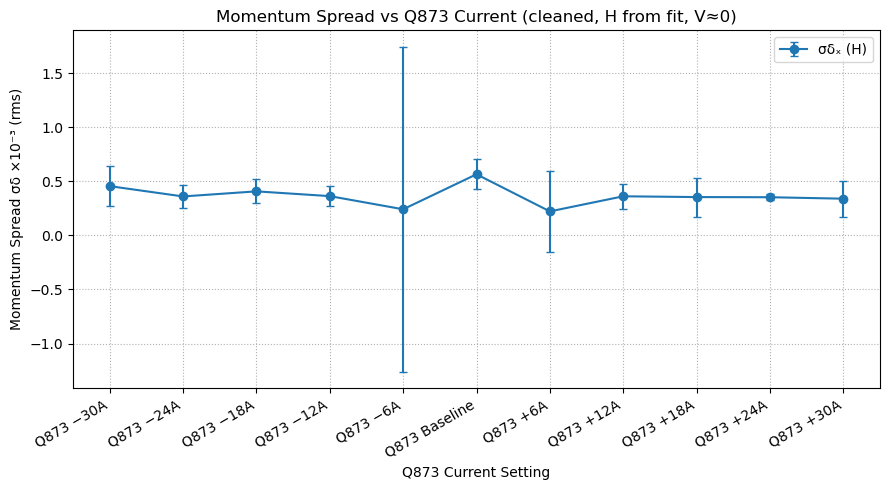

Wrote momentum_spread_vs_Q873_current_clean.csv


In [14]:
# =========================================
# Momentum Spread (σδ) vs Q873 Current 
# =========================================
# Replace any absurd σδ_y values (from ill-conditioned fit) with NaN
sdy_arr = np.array(sdy)
sdy_std_arr = np.array(sdy_std)

# optional sanity filter: if σδ_y > 5× typical horizontal, set to NaN
typical_sdx = np.nanmedian(np.array(sdx))
mask_bad = sdy_arr > 5 * typical_sdx
sdy_arr[mask_bad] = np.nan
sdy_std_arr[mask_bad] = np.nan

plt.figure(figsize=(9,5))
plt.errorbar(xs, np.array(sdx)*1e3, yerr=np.array(sdx_std)*1e3,
             marker="o", linestyle="-", capsize=3, label="σδₓ (H)")
#plt.errorbar(xs, sdy_arr*1e3, yerr=sdy_std_arr*1e3,
             #marker="s", linestyle="-", capsize=3, label="σδᵧ (V)")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("Momentum Spread σδ ×10⁻³ (rms)")
plt.title("Momentum Spread vs Q873 Current (cleaned, H from fit, V≈0)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# ---- save cleaned data ----
sdel_df = pd.DataFrame({
    "sigma_delta_x [rms]": sdx,
    "sigma_delta_x_std": sdx_std,
    "sigma_delta_y [rms]": sdy_arr,
    "sigma_delta_y_std": sdy_std_arr,
}, index=xtick_labels)
sdel_df.to_csv("momentum_spread_vs_Q873_current_clean.csv")
print("Wrote momentum_spread_vs_Q873_current_clean.csv")



Wrote momentum_spread_Dp_horizontal_vs_Q873_current.csv


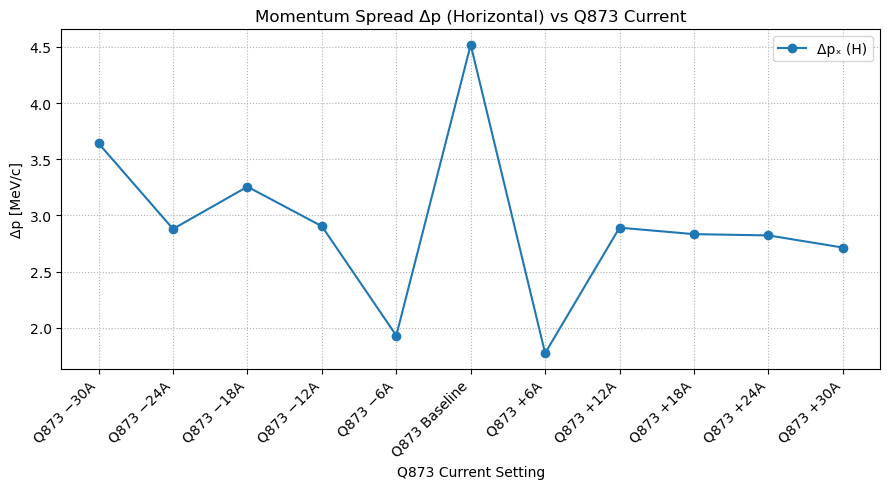

In [15]:
# ───────────────────────────────────────────────────────────────
# Δp (horizontal) vs Q873 current
# based on your momentum_spread_vs_Q873_current_clean.csv
# ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# reference momentum
p0 = 8000.0  # [MeV/c]

# ── load your cleaned σδ results ────────────────────────────────
df = pd.read_csv("momentum_spread_vs_Q873_current_clean.csv", index_col=0)

# make sure column name matches — adjust if needed
col = next((c for c in df.columns if "H" in c or "sigma_delta_x" in c.lower()), None)
if col is None:
    raise ValueError("Couldn't find horizontal σδ column in CSV!")

# compute Δp = σδ × p₀
df["Δp_x [MeV/c]"] = df[col] * p0

# optional error column if exists
err_col = next((c for c in df.columns if "err" in c.lower() and "H" in c), None)
dp_err = df[err_col] * p0 if err_col else None

# save CSV with Δp
out_csv = "momentum_spread_Dp_horizontal_vs_Q873_current.csv"
df.to_csv(out_csv)
print(f"Wrote {out_csv}")

# ── make the plot ───────────────────────────────────────────────
plt.figure(figsize=(9,5))
plt.errorbar(
    df.index, df["Δp_x [MeV/c]"], 
    yerr=dp_err, fmt="o-", capsize=3, lw=1.5, 
    label="Δpₓ (H)"
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Q873 Current Setting")
plt.ylabel("Δp [MeV/c]")
plt.title("Momentum Spread Δp (Horizontal) vs Q873 Current")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
import math, re, pandas as pd

twiss_path = "twiss_Q873_default.tfs"
monitor = "MW876"           # Near target
sigma_x_mm = 4.8            # measured horizontal beam size [mm]
emittance_x = 1.322e-6      # from baseline fit [m·rad]

# --- Read the TFS file ---
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    header_idx = next(i for i,l in enumerate(lines) if l.lstrip().startswith("*"))
    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    data_rows = [ln for ln in lines[start:] if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)), sep=r"\s+", header=None, names=cols, engine="python")
    df.columns = [c.upper() for c in df.columns]
    df["NAME"] = df["NAME"].astype(str).str.upper().str.strip('"').str.strip("'")
    return df

def get_monitor_row(df, name):
    row = df[df["NAME"].str.contains(name.upper(), na=False)]
    if row.empty: raise ValueError(f"{name} not found in TFS")
    return row.iloc[0]

df = read_tfs(twiss_path)
row = get_monitor_row(df, monitor)
beta_x = float(row["BETX"])
Dx = float(row["DX"])

# --- Compute sigma_delta ---
sigma_x_m = sigma_x_mm * 1e-3
s2 = sigma_x_m**2 - beta_x * emittance_x
sigma_delta = math.sqrt(s2 / Dx**2)
delta_p = sigma_delta * 8000.0   # in MeV/c, assuming 8 GeV beam

print(f"Monitor       : {monitor}")
print(f"σₓ            : {sigma_x_mm:.3f} mm")
print(f"βₓ            : {beta_x:.4f} m")
print(f"Dₓ            : {Dx:.4f} m")
print(f"εₓ            : {emittance_x:.3e} m·rad")
print(f"→ σδ          = {sigma_delta:.4e}")
print(f"→ Δp          = {delta_p:.2f} MeV/c")


Monitor       : MW876
σₓ            : 4.800 mm
βₓ            : 6.1510 m
Dₓ            : -4.8645 m
εₓ            : 1.322e-06 m·rad
→ σδ          = 7.9374e-04
→ Δp          = 6.35 MeV/c


In [17]:
import math, re, pandas as pd, numpy as np

# =========================================
# Narrow bunch beam sigmas (from your data)
# =========================================
sigx_mm = {"MW873": 1.717, "MW875": 6.145, "MW876": 4.745}
sigy_mm = {"MW873": 4.795, "MW875": 2.696, "MW876": 1.918}

# =========================================
# Twiss file (for same optics)
# =========================================
twiss_path = "twiss_Q873_default.tfs"
monitors = ["MW873","MW875","MW876"]

# =========================================
# TFS reader helpers
# =========================================
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    header_idx = next(i for i,l in enumerate(lines) if l.lstrip().startswith("*"))
    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    data_rows = [ln for ln in lines[start:]
                 if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=cols, engine="python")
    df.columns = [c.upper() for c in df.columns]
    df["NAME"] = (df["NAME"].astype(str).str.upper()
                  .str.strip('"').str.strip("'").str.strip())
    return df

def get_mw_rows(df, names):
    out = {}
    for name in names:
        row = df[df["NAME"].str.contains(name.upper(), na=False)]
        if row.empty:
            raise ValueError(f"{name} not found in TFS file")
        out[name] = row.iloc[0]
    return out

# =========================================
# Fit function for ε and σδ²
# =========================================
def fit_eps_sdel2(sig_mm_list, beta_list, disp_list):
    y = np.array([(s*1e-3)**2 for s in sig_mm_list])  # σ² [m²]
    X = np.column_stack([np.array(beta_list), np.array(disp_list)**2])
    (eps, sdel2), *_ = np.linalg.lstsq(X, y, rcond=None)
    return max(float(eps), 0.0), max(float(sdel2), 0.0)

# =========================================
# Load Twiss & extract parameters
# =========================================
df = read_tfs(twiss_path)
rows = get_mw_rows(df, monitors)

betx = [float(rows[w]["BETX"]) for w in monitors]
dx   = [float(rows[w]["DX"])   for w in monitors]
bety = [float(rows[w]["BETY"]) for w in monitors]
dy   = [float(rows[w]["DY"])   for w in monitors]

sigx_list = [sigx_mm[w] for w in monitors]
sigy_list = [sigy_mm[w] for w in monitors]

# =========================================
# Perform 2-parameter fits
# =========================================
epsx, sdel2x = fit_eps_sdel2(sigx_list, betx, dx)
epsy, sdel2y = fit_eps_sdel2(sigy_list, bety, dy)

sigma_delta_x = math.sqrt(sdel2x)
delta_p_x = sigma_delta_x * 8000.0  # MeV/c for 8 GeV beam

print("=== Narrow Bunch Mode Fit ===")
print(f"εₓ (geom)        = {epsx:.3e} m·rad")
print(f"σδₓ (rms)        = {sigma_delta_x:.3e}")
print(f"Δpₓ              = {delta_p_x:.2f} MeV/c")
print()
print(f"εᵧ (geom)        = {epsy:.3e} m·rad")
print(f"σδᵧ (rms)        = {math.sqrt(sdel2y):.3e}")


=== Narrow Bunch Mode Fit ===
εₓ (geom)        = 3.096e-07 m·rad
σδₓ (rms)        = 9.646e-04
Δpₓ              = 7.72 MeV/c

εᵧ (geom)        = 0.000e+00 m·rad
σδᵧ (rms)        = 3.750e-01


In [18]:
import math

def compute_momentum_spread(sigma_x_mm, beta_x_m, dispersion_x_m, emittance_x_mrad, p0_mev_c=8000.0):
    """
    Calculates relative and absolute momentum spread from sigma_x, beta_x, Dx, and emittance_x.

    Parameters:
        sigma_x_mm (float): Measured sigma_x in mm
        beta_x_m (float): Beta function in m
        dispersion_x_m (float): Dispersion Dx in m
        emittance_x_mrad (float): Emittance in m·rad
        p0_mev_c (float): Reference momentum (default: 8000 MeV/c)

    Returns:
        sigma_delta (float): Relative momentum spread (unitless)
        delta_p (float): Absolute momentum spread in MeV/c
    """
    # Convert sigma_x to meters
    sigma_x_m = sigma_x_mm * 1e-3

    # Compute numerator and denominator
    numerator = sigma_x_m**2 - beta_x_m * emittance_x_mrad
    denominator = dispersion_x_m**2

    if denominator <= 0 or numerator < 0:
        raise ValueError("Invalid parameters: result would be complex or undefined.")

    sigma_delta = math.sqrt(numerator / denominator)
    delta_p = sigma_delta * p0_mev_c

    return sigma_delta, delta_p

# === Example input ===
sigma_x_mm     = 1.717         # σₓ in mm
beta_x_m       = 3.4091        # βₓ in m (from Twiss)
dispersion_x_m = -1.3702       # Dₓ in m (from Twiss)
emittance_x    = 3.096e-7      # εₓ in m·rad (from fit)
p0_mev_c       = 8000.0        # reference momentum in MeV/c

# === Run calculation ===
sigma_delta, delta_p = compute_momentum_spread(
    sigma_x_mm,
    beta_x_m,
    dispersion_x_m,
    emittance_x,
    p0_mev_c
)

# === Print result ===
print(f"Sigma_x       : {sigma_x_mm:.4f} mm")
print(f"Beta_x        : {beta_x_m:.4f} m")
print(f"Dispersion Dx : {dispersion_x_m:.4f} m")
print(f"Emittance     : {emittance_x:.3e} m·rad")
print(f"→ σδ          = {sigma_delta:.4e}")
print(f"→ Δp          = {delta_p:.2f} MeV/c")


Sigma_x       : 1.7170 mm
Beta_x        : 3.4091 m
Dispersion Dx : -1.3702 m
Emittance     : 3.096e-07 m·rad
→ σδ          = 1.0040e-03
→ Δp          = 8.03 MeV/c


βγ = 9.416139  |  fitted σδ = 7.401e-04
Wrote CSVs: Dx_estimates_vs_current.csv, Dy_estimates_vs_current.csv, target_sigma_prediction_scaled_D.csv


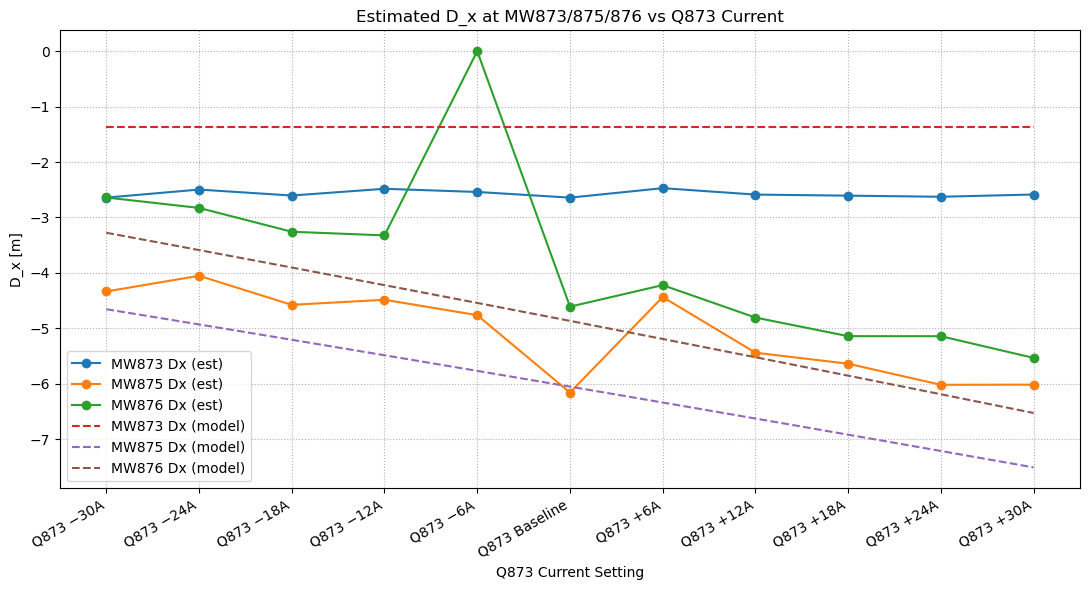

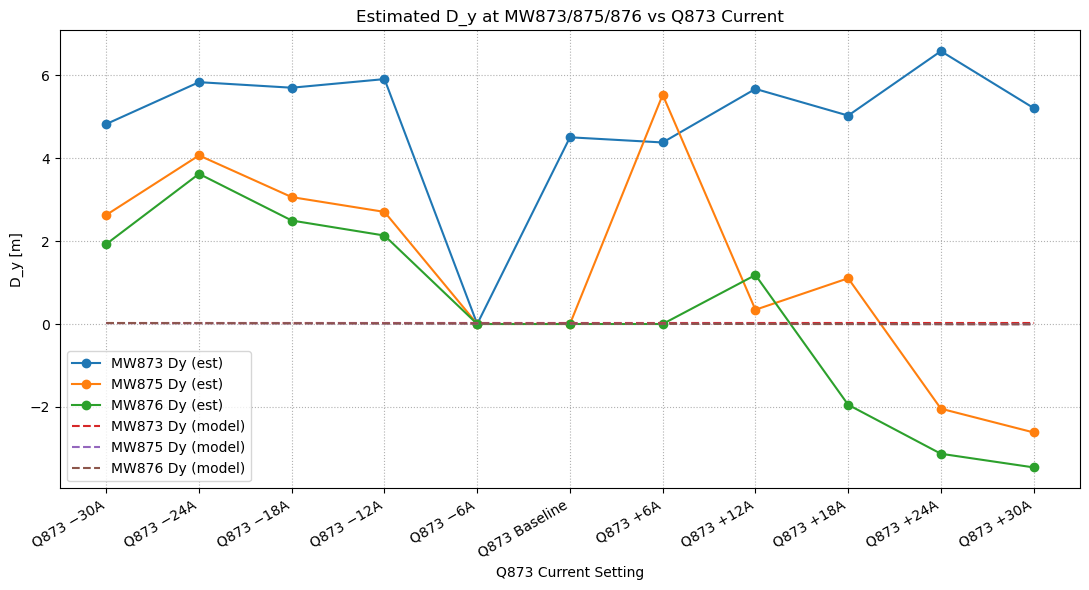

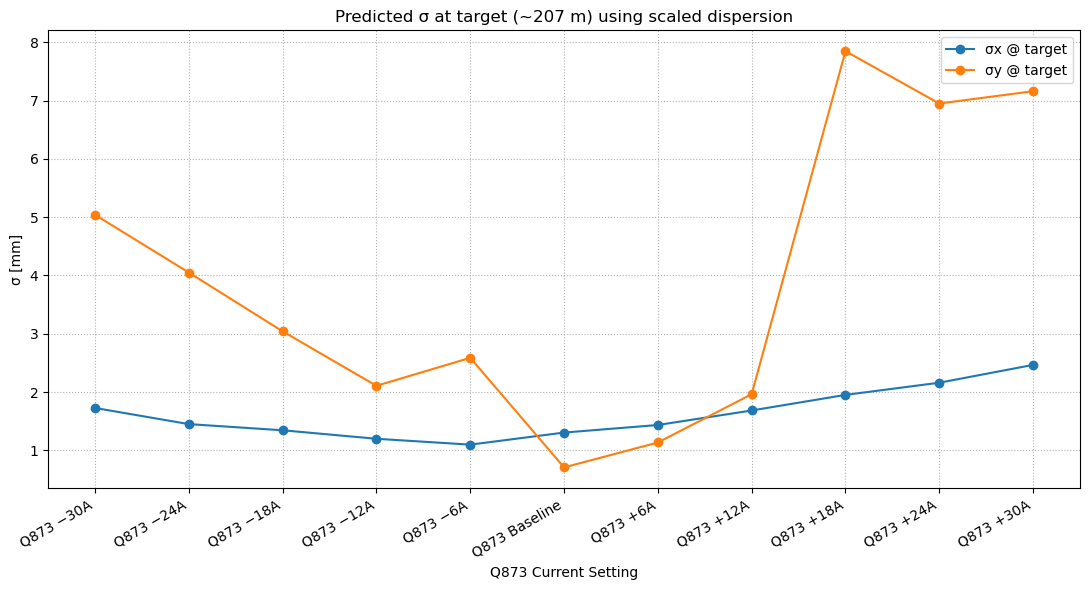

In [19]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# Where are the files?
# =========================================================
BASE = "."  # change if your TFS/CSV live elsewhere

def P(path):  # join helper
    return path if os.path.isabs(path) else os.path.join(BASE, path)

# =========================================================
#  File maps — prefer flipped polarity when present
# =========================================================
files_flip = {
    "-30": "twiss_Q873_-30A_flipPol.tfs",
    "-24": "twiss_Q873_-24A_flipPol.tfs",
    "-18": "twiss_Q873_-18A_flipPol.tfs",
    "-12": "twiss_Q873_-12A_flipPol.tfs",
    "-6" : "twiss_Q873_-6A_flipPol.tfs",
    "0"  : "twiss_Q873_default.tfs",  # baseline
    "+6" : "twiss_Q873_+6A_flipPol.tfs",
    "+12": "twiss_Q873_+12A_flipPol.tfs",
    "+18": "twiss_Q873_+18A_flipPol.tfs",
    "+24": "twiss_Q873_+24A_flipPol.tfs",
    "+30": "twiss_Q873_+30A_flipPol.tfs",
}
files_orig = {
    "-30": "twiss_Q873_minus30A.tfs",
    "-24": "twiss_Q873_minus24A.tfs",
    "-18": "twiss_Q873_minus18A.tfs",
    "-12": "twiss_Q873_minus12A.tfs",
    "-6" : "twiss_Q873_minus6A.tfs",
    "0"  : "twiss_Q873_default.tfs",
    "+6" : "twiss_Q873_plus6A.tfs",
    "+12": "twiss_Q873_plus12A.tfs",
    "+18": "twiss_Q873_plus18A.tfs",
    "+24": "twiss_Q873_plus24A.tfs",
    "+30": "twiss_Q873_plus30A.tfs",
}

order = ["-30","-24","-18","-12","-6","0","+6","+12","+18","+24","+30"]
xlabels = {
    "-30":"Q873 −30A","-24":"Q873 −24A","-18":"Q873 −18A","-12":"Q873 −12A","-6":"Q873 −6A",
    "0":"Q873 Baseline","+6":"Q873 +6A","+12":"Q873 +12A","+18":"Q873 +18A","+24":"Q873 +24A","+30":"Q873 +30A"
}
monitors = ["MW873","MW875","MW876"]

def choose_files():
    chosen = {}
    for k in order:
        f = files_flip.get(k)
        if f and os.path.exists(P(f)):
            chosen[k] = P(f)
        elif files_orig.get(k) and os.path.exists(P(files_orig[k])):
            chosen[k] = P(files_orig[k])
    return chosen

files = choose_files()
if "0" not in files:
    raise RuntimeError("Baseline 0A TFS not found.")

# =========================================================
# Measured σ (mm) table (as provided)
# =========================================================
meas_data = {
    "Q873 − 30A":    [2.30,  5.05,  3.56,  4.50,  2.29,  4.40],
    "Q873 − 24A":    [2.20,  4.95,  3.40,  3.84,  2.44,  3.60],
    "Q873 − 18A":    [2.29,  5.01,  3.81,  3.20,  2.78,  2.89],
    "Q873 − 12A":    [2.19,  4.97,  3.76,  2.58,  2.84,  2.21],
    "Q873 − 6A":     [2.18,  5.00,  3.92,  1.95,  0.745, 1.56],
    "Q873 Baseline": [2.293, 4.959, 4.957, 1.371, 3.771, 0.9685],
    "Q873 + 6A":     [2.22,  5.01,  3.92,  4.22,  3.60,  0.538],
    "Q873 + 12A":    [2.30,  5.01,  4.62,  0.487, 4.04,  0.950],
    "Q873 + 18A":    [2.32,  5.03,  4.81,  0.918, 4.32,  1.64],
    "Q873 + 24A":    [2.33,  5.05,  5.10,  1.54,  4.37,  2.37],
    "Q873 + 30A":    [2.30,  5.02,  5.14,  2.23,  4.67,  3.07],
}
meas_df = pd.DataFrame.from_dict(
    meas_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

def find_meas_row(label):
    """Robust matching: ignore spaces."""
    target = label.replace(" ", "")
    for idx in meas_df.index:
        if idx.replace(" ", "") == target:
            return meas_df.loc[idx]
    raise KeyError(f"Measurement row not found for '{label}'")

# =========================================================
# TFS reader + helpers
# =========================================================
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    # header
    hdr = None
    for i, ln in enumerate(lines):
        if ln.lstrip().startswith("*"):
            hdr = i; break
    if hdr is None:
        raise RuntimeError(f"No '*' header line in {path}")
    cols = re.sub(r"^\*", "", lines[hdr]).strip().split()
    # data start
    start = hdr + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    # keep data rows
    rows = []
    for ln in lines[start:]:
        if ln.strip()=="" or ln.lstrip().startswith(("@","#","*","$")):
            continue
        rows.append(ln)
    from io import StringIO
    df = pd.read_csv(StringIO("".join(rows)), sep=r"\s+", header=None, names=cols, engine="python")
    # normalize
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_rows(df, name_list):
    out = {}
    for n in name_list:
        m = df[df["NAME"]==n]
        if m.empty:
            m = df[df["NAME"].str.startswith(n)]
        out[n] = None if m.empty else m.iloc[0]
    return out

def pick_target_row(df):
    # try by name
    for n in ["MTGT","MWTGT","TARGET","TGT","MTGT1"]:
        m = df[df["NAME"]==n]
        if not m.empty:
            return m.iloc[0]
    # else by S ~ 206–208.5 m (closest to 207)
    if "S" in df.columns:
        window = df[(df["S"]>=206.0) & (df["S"]<=208.5)]
        i = (window["S"]-207.0).abs().idxmin() if not window.empty else (df["S"]-207.0).abs().idxmin()
        return df.loc[i]
    raise RuntimeError("Could not locate target row by name or S-range")

# =========================================================
# Beam βγ and emittance conversion
# =========================================================
p_GeV = 8.83490
m0_GeV = 0.9382720813
gamma = math.sqrt(1.0 + (p_GeV/m0_GeV)**2)
beta = math.sqrt(1.0 - 1.0/gamma**2)
betagamma = beta*gamma

def eps95norm_to_epsrms(eps95_norm_pi_mm_mrad):
    """
    95% normalized emittance (π·mm·mrad) -> ε_rms geometric (m·rad):
    ε_95,norm ≈ 6 * (βγ * ε_rms) [π·mm·mrad]
    """
    return (eps95_norm_pi_mm_mrad / 6.0) * 1e-6 / betagamma

# Load per-current ε95,normalized if CSV exists, else default constants
eps95_csv = P("emittance95_normalized_pi-mm-mrad.csv")
if os.path.exists(eps95_csv):
    eps_tab = pd.read_csv(eps95_csv, index_col=0)
    # find columns that look like ex/ey
    col_ex = [c for c in eps_tab.columns if "ex" in c.lower()]
    col_ey = [c for c in eps_tab.columns if "ey" in c.lower()]
    if not col_ex: col_ex = [eps_tab.columns[0]]
    if not col_ey: col_ey = [eps_tab.columns[1]]
    eps95_norm_map_x = {idx: float(eps_tab.loc[idx, col_ex[0]]) for idx in eps_tab.index}
    eps95_norm_map_y = {idx: float(eps_tab.loc[idx, col_ey[0]]) for idx in eps_tab.index}
else:
    # fallback: design-like constants
    eps95_norm_map_x = {xlabels[k]:20.0 for k in order}  # π·mm·mrad
    eps95_norm_map_y = {xlabels[k]:12.0 for k in order}  # π·mm·mrad
    print("WARNING: no emittance CSV found; using defaults ex95=20, ey95=12 π·mm·mrad.")

epsx_rms_map = {}
epsy_rms_map = {}
for k in order:
    lbl = xlabels[k]
    if lbl in eps95_norm_map_x and lbl in eps95_norm_map_y:
        epsx_rms_map[k] = eps95norm_to_epsrms(eps95_norm_map_x[lbl])
        epsy_rms_map[k] = eps95norm_to_epsrms(eps95_norm_map_y[lbl])

# =========================================================
# Fit σδ at baseline (horizontal)
#    y_i = σx_i^2 − εx*βx_i = (σδ^2) D_i^2  at three wires
# =========================================================
df0 = read_tfs(files["0"])
rows0 = get_rows(df0, monitors)
meas0 = find_meas_row("Q873 Baseline")
Y = []
X = []
for w, colH in [("MW873","873 H"),("MW875","875 H"),("MW876","876 H")]:
    r = rows0[w]
    if r is None:
        continue
    sx = float(meas0[colH]) * 1e-3
    bx = float(r["BETX"])
    Dx = float(r["DX"])
    Y.append(sx*sx - epsx_rms_map["0"]*bx)
    X.append([Dx*Dx])
s2, *_ = np.linalg.lstsq(np.array(X), np.array(Y), rcond=None)
sigma_delta = math.sqrt(max(float(s2[0]), 0.0))
sigma_delta_y = sigma_delta  # same energy spread

print(f"βγ = {betagamma:.6f}  |  fitted σδ = {sigma_delta:.3e}")

# =========================================================
# For each current: estimate D at wires; scale model; predict σ at target
# =========================================================
Dx_est = {w: [] for w in monitors}
Dy_est = {w: [] for w in monitors}
Dx_mod = {w: [] for w in monitors}
Dy_mod = {w: [] for w in monitors}
labels_avail = []
target_sigmas = []

def median_scale(est_list, mod_list):
    ratios = [e/m for e, m in zip(est_list, mod_list) if (m is not None and abs(m)>1e-12)]
    return float(np.median(ratios)) if ratios else 1.0

for k in order:
    if k not in files:  # missing file
        continue
    df = read_tfs(files[k])
    rows = get_rows(df, monitors)
    labels_avail.append(k)

    # measured sigmas for this current
    mrow = find_meas_row(xlabels[k])

    # gather per-wire estimates & models
    est_dx, mod_dx = [], []
    est_dy, mod_dy = [], []

    for w, (colH, colV) in zip(monitors, [("873 H","873 V"),("875 H","875 V"),("876 H","876 V")]):
        r = rows[w]
        if r is None:
            Dx_est[w].append(np.nan); Dy_est[w].append(np.nan)
            Dx_mod[w].append(np.nan); Dy_mod[w].append(np.nan)
            continue
        # optics
        bx = float(r["BETX"]); by = float(r["BETY"])
        Dx_m = float(r["DX"]);  Dy_m = float(r["DY"])
        # measured (m)
        sx_m = float(mrow[colH])*1e-3
        sy_m = float(mrow[colV])*1e-3
        # emittances at this current
        ex = epsx_rms_map[k]; ey = epsy_rms_map[k]

        # invert for D (clip negative under the root)
        base_x = max(sx_m*sx_m - ex*bx, 0.0)
        base_y = max(sy_m*sy_m - ey*by, 0.0)
        Dx_e = 0.0 if sigma_delta<=0 else math.sqrt(base_x) / sigma_delta
        Dy_e = 0.0 if sigma_delta_y<=0 else math.sqrt(base_y) / sigma_delta_y
        # carry model sign so phases look right
        if abs(Dx_m) > 1e-12: Dx_e = math.copysign(Dx_e, Dx_m)
        if abs(Dy_m) > 1e-12: Dy_e = math.copysign(Dy_e, Dy_m)

        Dx_est[w].append(Dx_e); Dy_est[w].append(Dy_e)
        Dx_mod[w].append(Dx_m); Dy_mod[w].append(Dy_m)
        est_dx.append(Dx_e); mod_dx.append(Dx_m)
        est_dy.append(Dy_e); mod_dy.append(Dy_m)

    # scale model dispersion for this current using median ratio across wires
    kx = median_scale(est_dx, mod_dx)
    ky = median_scale(est_dy, mod_dy)

    # pick target row (~207 m or by name)
    tgt = pick_target_row(df)
    Dx_tgt = float(tgt["DX"]) * kx
    Dy_tgt = float(tgt["DY"]) * ky
    ex = epsx_rms_map[k]; ey = epsy_rms_map[k]
    sigx_tgt_mm = math.sqrt(max(ex*float(tgt["BETX"]) + (sigma_delta*Dx_tgt)**2, 0.0))*1e3
    sigy_tgt_mm = math.sqrt(max(ey*float(tgt["BETY"]) + (sigma_delta*Dy_tgt)**2, 0.0))*1e3

    target_sigmas.append({
        "label": xlabels[k],
        "sigx_mm": sigx_tgt_mm,
        "sigy_mm": sigy_tgt_mm,
        "kx": kx, "ky": ky,
        "Dx_tgt_scaled": Dx_tgt, "Dy_tgt_scaled": Dy_tgt,
        "Dx_tgt_model": float(tgt["DX"]), "Dy_tgt_model": float(tgt["DY"]),
        "BETX_tgt": float(tgt["BETX"]), "BETY_tgt": float(tgt["BETY"]),
        "S_tgt": float(tgt["S"]) if "S" in tgt.index else np.nan
    })

# =========================================================
# Tables + CSVs
# =========================================================
xs = [xlabels[k] for k in labels_avail]
dx_table = pd.DataFrame({
    "Dx_est_MW873": Dx_est["MW873"],
    "Dx_est_MW875": Dx_est["MW875"],
    "Dx_est_MW876": Dx_est["MW876"],
    "Dx_model_MW873": Dx_mod["MW873"],
    "Dx_model_MW875": Dx_mod["MW875"],
    "Dx_model_MW876": Dx_mod["MW876"],
}, index=xs)
dy_table = pd.DataFrame({
    "Dy_est_MW873": Dy_est["MW873"],
    "Dy_est_MW875": Dy_est["MW875"],
    "Dy_est_MW876": Dy_est["MW876"],
    "Dy_model_MW873": Dy_mod["MW873"],
    "Dy_model_MW875": Dy_mod["MW875"],
    "Dy_model_MW876": Dy_mod["MW876"],
}, index=xs)
tgt_df = pd.DataFrame(target_sigmas).set_index("label").loc[xs]

dx_table.to_csv(P("Dx_estimates_vs_current.csv"))
dy_table.to_csv(P("Dy_estimates_vs_current.csv"))
tgt_df.to_csv(P("target_sigma_prediction_scaled_D.csv"))

print("Wrote CSVs:",
      "Dx_estimates_vs_current.csv, Dy_estimates_vs_current.csv, target_sigma_prediction_scaled_D.csv")

# =========================================================
# Plots
# =========================================================
xi = np.arange(len(xs))

# 8a) D_x vs current (est + model)
plt.figure(figsize=(11,6))
plt.plot(xi, dx_table["Dx_est_MW873"], marker="o", label="MW873 Dx (est)")
plt.plot(xi, dx_table["Dx_est_MW875"], marker="o", label="MW875 Dx (est)")
plt.plot(xi, dx_table["Dx_est_MW876"], marker="o", label="MW876 Dx (est)")
plt.plot(xi, dx_table["Dx_model_MW873"], linestyle="--", label="MW873 Dx (model)")
plt.plot(xi, dx_table["Dx_model_MW875"], linestyle="--", label="MW875 Dx (model)")
plt.plot(xi, dx_table["Dx_model_MW876"], linestyle="--", label="MW876 Dx (model)")
plt.xticks(xi, xs, rotation=30, ha="right")
plt.ylabel("D_x [m]")
plt.xlabel("Q873 Current Setting")
plt.title("Estimated D_x at MW873/875/876 vs Q873 Current")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# 8b) D_y vs current (est + model)
plt.figure(figsize=(11,6))
plt.plot(xi, dy_table["Dy_est_MW873"], marker="o", label="MW873 Dy (est)")
plt.plot(xi, dy_table["Dy_est_MW875"], marker="o", label="MW875 Dy (est)")
plt.plot(xi, dy_table["Dy_est_MW876"], marker="o", label="MW876 Dy (est)")
plt.plot(xi, dy_table["Dy_model_MW873"], linestyle="--", label="MW873 Dy (model)")
plt.plot(xi, dy_table["Dy_model_MW875"], linestyle="--", label="MW875 Dy (model)")
plt.plot(xi, dy_table["Dy_model_MW876"], linestyle="--", label="MW876 Dy (model)")
plt.xticks(xi, xs, rotation=30, ha="right")
plt.ylabel("D_y [m]")
plt.xlabel("Q873 Current Setting")
plt.title("Estimated D_y at MW873/875/876 vs Q873 Current")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# 8c) σ at target vs current (using scaled D)
plt.figure(figsize=(11,6))
plt.plot(xi, tgt_df["sigx_mm"], marker="o", label="σx @ target")
plt.plot(xi, tgt_df["sigy_mm"], marker="o", label="σy @ target")
plt.xticks(xi, xs, rotation=30, ha="right")
plt.ylabel("σ [mm]")
plt.xlabel("Q873 Current Setting")
plt.title("Predicted σ at target (~207 m) using scaled dispersion")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd

q873 = pd.read_csv("target_sigma_prediction_scaled_D_Q873.csv", index_col=0)

# Compute effective beam spot area = σx * σy
q873["area_mm2"] = q873["sigx_mm"] * q873["sigy_mm"]

# Find best (smallest area)
best = q873["area_mm2"].idxmin()

print("Q873 best optics:")
print(f"  Setting: {best}")
print(f"  σx = {q873.loc[best,'sigx_mm']:.2f} mm")
print(f"  σy = {q873.loc[best,'sigy_mm']:.2f} mm")
print(f"  Area = {q873.loc[best,'area_mm2']:.2f} mm²")

print("\nBaseline optics:")
print(f"  σx = {q873.loc['Q873 Baseline','sigx_mm']:.2f} mm")
print(f"  σy = {q873.loc['Q873 Baseline','sigy_mm']:.2f} mm")
print(f"  Area = {q873.loc['Q873 Baseline','area_mm2']:.2f} mm²")


Q873 best optics:
  Setting: Q873 Baseline
  σx = 1.30 mm
  σy = 0.71 mm
  Area = 0.92 mm²

Baseline optics:
  σx = 1.30 mm
  σy = 0.71 mm
  Area = 0.92 mm²


In [21]:
import pandas as pd

q874 = pd.read_csv("target_sigma_prediction_scaled_D_Q874.csv", index_col=0)

# Compute effective beam spot area = σx * σy
q874["area_mm2"] = q874["sigx_mm"] * q874["sigy_mm"]

# Find best (smallest area)
best = q874["area_mm2"].idxmin()

print("Q874 best optics:")
print(f"  Setting: {best}")
print(f"  σx = {q874.loc[best,'sigx_mm']:.2f} mm")
print(f"  σy = {q874.loc[best,'sigy_mm']:.2f} mm")
print(f"  Area = {q874.loc[best,'area_mm2']:.2f} mm²")

print("\nBaseline optics:")
print(f"  σx = {q874.loc['Q874 Baseline','sigx_mm']:.2f} mm")
print(f"  σy = {q874.loc['Q874 Baseline','sigy_mm']:.2f} mm")
print(f"  Area = {q874.loc['Q874 Baseline','area_mm2']:.2f} mm²")


Q874 best optics:
  Setting: Q874 − 27A
  σx = 1.09 mm
  σy = 2.01 mm
  Area = 2.19 mm²

Baseline optics:
  σx = 6.55 mm
  σy = 3.24 mm
  Area = 21.20 mm²
